# Baseline Retrieval Teljesítmény Kiértékelése

Ez a notebook a hybrid search (BM25 + FAISS + RRF fusion) baseline teljesítményét értékeli ki.

**Célok:**
- Qrels alapú kiértékelés (nDCG@10, MAP, Recall@K, MRR)
- Baseline score meghatározása GRPO összehasonlításhoz
- Részletes analitika query-szinten és aggregált szinten
- Eredmények mentése későbbi felhasználásra

**Fusion módszer:** RRF (Reciprocal Rank Fusion) - robusztus, skála-független


In [ ]:
import json
import sys
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ranx import Qrels, Run, evaluate

# Project root setup
project_root = Path("/workspace") if Path("/workspace").exists() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from configs import config
from scripts.hybrid_retrieval import HybridRetriever

print(f"📂 Project root: {project_root}")
print(f"✅ Importok betöltve (ranx használatával)")


🔌 GPU Információk:
  CUDA elérhető: False
  ℹ️ CUDA nem elérhető - CPU módban fut
⚠️ HuggingFace token nem található (HUGGINGFACE_TOKEN env var)
📂 Workspace és fájlok:
  Base path: /Users/zelenyianszkimate/Documents/CourtRankRL
  Chunks: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/chunks.jsonl
  BM25 index: /Users/zelenyianszkimate/Documents/CourtRankRL/data/index/bm25/bm25s_model
  FAISS index: /Users/zelenyianszkimate/Documents/CourtRankRL/data/index/faiss_index.bin
  Queries: /Users/zelenyianszkimate/Documents/CourtRankRL/data/qrels/sample_queries.txt
  Output: /Users/zelenyianszkimate/Documents/CourtRankRL/data/qrels/pipeline_results.jsonl

⚙️ Retrieval konfiguráció:
  Top-K baseline: 300
  Top-K reranked: 20

📋 Fájl ellenőrzés:
  ✅ chunks.jsonl
  ✅ BM25 index dir
  ✅ chunk_ids.json
  ✅ faiss_index.bin
  ✅ chunk_id_map.npy
  ✅ sample_queries.txt

✅ Konfiguráció és fájlellenőrzés kész

🔧 BM25 INDEX BETÖLTÉSE
✅ BM25S model betöltve: /Users/zelenyianszkimate/Document

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



✅ Test embedding:
   Shape: (768,)
   L2 norm: 1.000000 (kell: ~1.0)
   Non-zero: 768/768
✅ Embedding validáció sikeres

🔧 FAISS INDEX BETÖLTÉSE
📥 FAISS index betöltése...
✅ Index betöltve: 2,964,527 vektor
   Index típus: IndexPreTransform
   Dimenzió: 768
🎯 nprobe beállítva belső IVF-re: False, érték: 64
✅ Chunk ID mapping betöltve (ndarray): 2,964,527 elem

📋 QUERY LISTA BETÖLTÉSE
✅ 1000 query betöltve

Példa query-k (első 5):
  1. munkáltatói kártérítési felelősség munkáltatói utasítás jogszerűség jo...
  2. NAIH bírság panaszkezelés bizonyítás
  3. fellebbezés elkésett benyújtás igazolási kérelem
  4. tiltakozáshoz való jog panaszkezelés bizonyítás
  5. lopás vétség eljárás megszüntetése feltételei
  ... és még 995
✅ Helper függvények definiálva (ranx library integrációval)
   - strip_chunk_suffix: chunk_id → doc_id
   - aggregate_chunks_to_docs: chunk-level → doc-level (max-score)
   - rrf_fusion: BM25 + FAISS → RRF fusion (ranx.fuse - TREC-validated)
   - HybridRetriever: osztá

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  2/1000] NAIH bírság panaszkezelés bizonyítás                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  3/1000] fellebbezés elkésett benyújtás igazolási kérelem             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  4/1000] tiltakozáshoz való jog panaszkezelés bizonyítás              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  5/1000] lopás vétség eljárás megszüntetése feltételei                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  6/1000] tulajdonjog bejegyzés jegyzőkönyv bizonyító ereje elévülés   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  7/1000] káresemény bejelentés késedelme fizetési meghagyás ellentmon 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  8/1000] rt közgyűlés határozat érvénytelenség kártérítési felelősség 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[  9/1000] törléshez való jog érintetti kérelem elutasítás mértéke      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 10/1000] telekhatár vita jegyzőkönyv bizonyító ereje jogkövetkezmény  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 11/1000] távmunka szabályok apaszabadság díjazás feltételei           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 12/1000] GDPR kártalanítás nem vagyoni kár érvényesítés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 13/1000] hivatalos személy elleni erőszak orvos sérelmére             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 14/1000] lakás kiürítése földhivatali eljárás elévülés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 15/1000] zálogszerződés érvényesség végrehajtás megszüntetése jogorvo 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 16/1000] közbeszerzési szerződés vételár megfizetés bizonyítás        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 17/1000] szakértő kirendelése határidő számítás érvényesítés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 18/1000] engedély nélküli vezetés vétség büntetés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 19/1000] lakás kiürítése jogosult kérelme érvényesítés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 20/1000] munkáltatói kártérítési felelősség szabadság megváltás mérté 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 21/1000] próbaidő munkaidő nyilvántartás                              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 22/1000] munkaviszony végkielégítés mértéke bizonyítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 23/1000] kkt tag kizárása kártérítési felelősség mértéke              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 24/1000] banki szerződés egyoldalú módosítás fizetési meghagyás ellen 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 25/1000] felülvizsgálat feltételei igazolási kérelem elévülés         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 26/1000] gyermektartásdíj megállapítás ideiglenes intézkedés elévülés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 27/1000] munkaidő-beosztás felmondási védelem                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 28/1000] szülői felügyelet gyakorlása költségviselés mértéke          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 29/1000] rongálás bűncselekmény minősítő körülmény jogorvoslat        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 30/1000] általános felelősség okozati összefüggés mértéke             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 31/1000] kártalanítás biztosítás tisztességtelen feltétel jogkövetkez 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 32/1000] bizonyítás indítvány igazolási kérelem mértéke               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 33/1000] fogyasztói szerződés fogyasztói jogok jogorvoslat            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 34/1000] vezető tisztségviselő felelőssége törvényességi felügyelet é 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 35/1000] előszerződés ingatlan érvénytelenség jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 36/1000] kártalanítás biztosítás behajtási költségátalány feltételei  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 37/1000] adatvédelmi jogsértés közrehatás bizonyítás                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 38/1000] biztosítási szerződés érvénytelenség                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 39/1000] építési engedély jogorvoslat jegyzőkönyv bizonyító ereje jog 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 40/1000] előszerződés ingatlan szomszédjog jogorvoslat                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 41/1000] szülői felügyelet gyakorlása mértéke érvényesítés            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 42/1000] egyesület alapszabály módosítás kártalanítás bizonyítás      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 43/1000] közlekedési kár kármegosztás jogkövetkezmény                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 44/1000] adásvételi szerződés hibás teljesítés bizonyítás             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 45/1000] fogyasztóvédelmi eljárás jogszerűség jogkövetkezmény         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 46/1000] munkaidő-beosztás anyasági védelem érvényesítés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 47/1000] óvadék ellenében szabadlábon hagyás                          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 48/1000] garázdaság közérdekű munka mértéke                           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 49/1000] engedély nélküli vezetés vétség jogosítvány lejárt           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 50/1000] lakás kiürítése használati díj                               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 51/1000] versenytilalmi megállapodás anyasági védelem jogorvoslat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 52/1000] haszonélvezet alapítása használati díj elévülés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 53/1000] csalás bűncselekmény elévülés mértéke                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 54/1000] gyermektartásdíj megállapítás szakértői bizonyítás érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 55/1000] személyi szabadság megsértése előzetes letartóztatás jogorvo 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 56/1000] végrendelet érvénytelenség szakértői bizonyítás jogorvoslat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 57/1000] jogerős ítélet hatályon kívül helyezése fellebbezés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 58/1000] versenyjogi bírság határidő túllépés jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 59/1000] zsarolás bűntett halmazat jogorvoslat                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 60/1000] faktoring szerződés tisztességtelen feltétel érvényesítés    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 61/1000] személyi szabadság megsértése bűntett                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 62/1000] kkt tag kizárása fizetésképtelenség mértéke                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 63/1000] túlóra elszámolás rehabilitációs hozzájárulás elévülés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 64/1000] kötelesrész igény megosztás jogorvoslat                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 65/1000] munkaszerződés érvénytelenség pótlék kifizetés jogorvoslat   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 66/1000] késedelmi kamat fizetési meghagyás ellentmondás mértéke      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 67/1000] kötelesrész igény szakértői bizonyítás elévülés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 68/1000] munkaviszony végkielégítés mérték                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 69/1000] szerződésen kívüli kártérítés okozati összefüggés bizonyítás 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 70/1000] tulajdonjog bejegyzés földhivatali eljárás jogorvoslat       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 71/1000] jogerős ítélet hatályon kívül helyezése felülvizsgálat       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 72/1000] szállítási szerződés árleszállítás bizonyítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 73/1000] kábítószer birtoklás előzetes letartóztatás jogkövetkezmény  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 74/1000] perújítás feltételei határidő számítás                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 75/1000] kkt tag kizárása összeférhetetlenség feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 76/1000] szolgalom bejegyzés földhivatali eljárás érvényesítés        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 77/1000] általános felelősség bizonyítási teher jogorvoslat           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 78/1000] káresemény bejelentés késedelme részletfizetés mértéke       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 79/1000] tartási szerződés árleszállítás feltételei                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 80/1000] személyi szabadság megsértése halmazat mértéke               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 81/1000] ingatlan adásvétel előleg visszafizetés jogkövetkezmény      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 82/1000] kötelesrész igény végrehajthatóság jogorvoslat               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 83/1000] munkáltatói kártérítési felelősség elmaradt bér feltételei   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 84/1000] hivatalos személy elleni erőszak bűntett                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 85/1000] magánokirat-hamisítás pénzbüntetés feltételei                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 86/1000] vezető tisztségviselő felelőssége kártalanítás jogorvoslat   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 87/1000] hivatali vesztegetés óvadék bizonyítás                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 88/1000] személyiségi jogsértés bizonyítási teher jogorvoslat         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 89/1000] adásvételi szerződés elállás jog elévülés                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 90/1000] vállalkozási szerződés foglaló sorsa feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 91/1000] kapcsolattartás korlátozása megosztás elévülés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 92/1000] vállalkozási szerződés szerződésszegés jogkövetkezmény felté 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 93/1000] kft üzletrész átruházás törvényességi felügyelet mértéke     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 94/1000] megbízási szerződés hibás teljesítés feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 95/1000] munkavállalói felmondás munkavégzés megtagadása jogszerű mér 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 96/1000] kábítószer birtoklás vétség kereskedés                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 97/1000] törléshez való jog bírság mértéke bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 98/1000] gyámság elrendelése elbírálás szempont mértéke               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[ 99/1000] baleseti kártérítés bizonyítási teher                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[100/1000] öröklési szerződés ideiglenes intézkedés feltételei          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[101/1000] munkaviszony határozott idő lejártakor megszüntetése         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[102/1000] munkaviszony felmondási idő számítása                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[103/1000] munkaviszony elmaradt munkanélküli segély                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[104/1000] különélés megállapítása végrehajthatóság jogorvoslat         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[105/1000] fellebbezés határideje költségkedvezmény feltételei          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[106/1000] kérelem elkésettség jogkövetkezmény mértéke                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[107/1000] hivatalos személy elleni erőszak rendőr sérelmére            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[108/1000] licencszerződés megtámadhatóság elévülés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[109/1000] szerződésen kívüli kártérítés elévülés jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[110/1000] fogyasztói szerződés kötbér érvényesítés elévülés            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[111/1000] felülvizsgálat feltételei költségkedvezmény érvényesítés     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[112/1000] munkaviszony munkavégzés megtagadása jogszerű érvényesítés   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[113/1000] végrendelet érvénytelenség költségviselés érvényesítés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[114/1000] zsarolás bűntett minősítő körülmény elévülés                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[115/1000] vezető tisztségviselő felelőssége összeférhetetlenség jogköv 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[116/1000] kábítószer birtoklás vétség fogyasztás céljából              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[117/1000] kapcsolattartás korlátozása ideiglenes intézkedés jogorvosla 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[118/1000] csalás bűncselekmény minősítő körülmény feltételei           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[119/1000] munkaviszony elmaradt betegszabadság díjazás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[120/1000] egyesület alapszabály módosítás pótbefizetés jogorvoslat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[121/1000] adásvételi szerződés birtokbaadás késedelem                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[122/1000] munkaviszony elmaradt táppénz megtérítés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[123/1000] garázdaság előzetes letartóztatás                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[124/1000] közbeszerzési szerződés birtokbaadás késedelem mértéke       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[125/1000] távmunka szabályok jogellenes megszüntetése                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[126/1000] közös tulajdon megszüntetése érvénytelenség bizonyítás       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[127/1000] ajándékozási szerződés megtámadhatóság jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[128/1000] ideiglenes intézkedés elutasítás méltányosság érvényesítés   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[129/1000] fogyasztói szerződés elállás jog jogkövetkezmény             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[130/1000] ingatlan adásvétel szerződésszegés jogkövetkezmény érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[131/1000] öröklési szerződés szakértői bizonyítás feltételei           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[132/1000] adásvételi szerződés általános szerződési feltételek tisztes 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[133/1000] versenyjogi bírság érintetti kérelem elutasítás érvényesítés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[134/1000] termékfelelősség elévülés mértéke                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[135/1000] kft üzletrész átruházás pótbefizetés feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[136/1000] közúti baleset gondatlan okozás figyelmetlenség              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[137/1000] szülői felügyelet gyakorlása ideiglenes intézkedés mértéke   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[138/1000] adásvételi szerződés jótállás kötelezettség                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[139/1000] ideiglenes intézkedés elutasítás költségkedvezmény érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[140/1000] gyermektartásdíj megállapítás költségviselés jogkövetkezmény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[141/1000] előszerződés ingatlan földhivatali eljárás bizonyítás        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[142/1000] házasság felbontása költségviselés bizonyítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[143/1000] kábítószer kereskedelem büntetés mértéke bizonyítás          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[144/1000] hatósági határozat bírósági felülvizsgálat arányosság elévül 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[145/1000] közúti baleset gondatlan okozás elsőbbség meg nem adás       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[146/1000] embercsempészés halmazat érvényesítés                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[147/1000] kézbesítési kifogás jogkövetkezmény elévülés                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[148/1000] haszonbérleti szerződés jótállás érvényesítés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[149/1000] termékfelelősség bizonyítási teher                           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[150/1000] késedelmi kamat behajtási költségátalány bizonyítás          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[151/1000] rongálás bűncselekmény előzetes letartóztatás érvényesítés   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[152/1000] hozzáférési jog gyakorlása bírság mértéke                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[153/1000] szerződésen kívüli kártérítés kárösszeg megállapítás jogorvo 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[154/1000] tiltakozáshoz való jog eljárási hiba jogkövetkezmény         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[155/1000] szolgalom bejegyzés jogosult kérelme mértéke                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[156/1000] birtokvédelem elővásárlási jog gyakorlása elévülés           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[157/1000] személyiségi jogsértés kárösszeg megállapítás jogkövetkezmén 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[158/1000] szülői felügyelet gyakorlása végrehajthatóság érvényesítés   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[159/1000] munkaviszony azonnali hatályú megszüntetése indok            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[160/1000] birtokvédelem jegyzőkönyv bizonyító ereje mértéke            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[161/1000] munkaviszony jogellenes megszüntetése rehabilitációs hozzájá 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[162/1000] sikkasztás bűntett egyezség a bűnösség beismeréséről elévülé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[163/1000] ideiglenes intézkedés feltételei határidő számítás jogorvosl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[164/1000] alapítvány célmódosítás határozat megtámadása bizonyítás     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[165/1000] szakértő kirendelése igazolási kérelem feltételei            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[166/1000] munkaviszony rendes felmondás jogellenesség                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[167/1000] lopás vétség próbaidő érvényesítés                           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[168/1000] lízing díjhátralék elengedés jogkövetkezmény                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[169/1000] biztosítási szerződés vételár megfizetés jogorvoslat         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[170/1000] tiltakozáshoz való jog érintetti kérelem elutasítás elévülés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[171/1000] munkavállalói felmondás felmondási idő jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[172/1000] hatósági határozat bírósági felülvizsgálat határidő túllépés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[173/1000] hitel felmondása részletfizetés mértéke                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[174/1000] adásvételi szerződés árleszállítás jogkövetkezmény           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[175/1000] megbízási szerződés előleg visszafizetés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[176/1000] lakás kiürítése szomszédjog bizonyítás                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[177/1000] ideiglenes intézkedés elutasítás jogkövetkezmény mértéke     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[178/1000] banki szerződés egyoldalú módosítás végrehajtás megszüntetés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[179/1000] munkáltatói kártérítési felelősség felmondási védelem érvény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[180/1000] adatkezelés jogalapja eljárási hiba jogkövetkezmény          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[181/1000] szakértő kirendelése jogkövetkezmény érvényesítés            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[182/1000] késedelmi kamat végrehajtás megszüntetése jogorvoslat        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[183/1000] csalás bűncselekmény halmazat jogkövetkezmény                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[184/1000] jogerős ítélet hatályon kívül helyezése kúria                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[185/1000] számlakövetelés fizetési meghagyás ellentmondás mértéke      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[186/1000] cégjegyzék bejegyzés törvényességi felügyelet elévülés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[187/1000] kötelesrész igény elbírálás szempont mértéke                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[188/1000] ideiglenes intézkedés feltételei igazolási kérelem jogorvosl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[189/1000] megbízási szerződés megtámadhatóság mértéke                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[190/1000] munkaviszony elmaradt gyermekápolási díj                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[191/1000] kft taggyűlés összehívása határozat megtámadása feltételei   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[192/1000] munkabér visszatartás kártérítés mértéke bizonyítás          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[193/1000] zálogszerződés érvényesség részletfizetés feltételei         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[194/1000] perújítás feltételei méltányosság jogorvoslat                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[195/1000] hivatalos személy elleni erőszak bűnismétlés bizonyítás      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[196/1000] orvosi műhiba felróhatóság                                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[197/1000] munkaviszony felmondási védelem alkalmazása                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[198/1000] közös tulajdon megszüntetése jegyzőkönyv bizonyító ereje     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[199/1000] tartási szerződés hibás teljesítés bizonyítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[200/1000] hatósági határozat bírósági felülvizsgálat jogszerűség mérté 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[201/1000] engedély nélküli vezetés elévülés bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[202/1000] kézbesítési kifogás határidő számítás jogkövetkezmény        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[203/1000] termékfelelősség közrehatás mértéke                          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[204/1000] perindítás illeték jogkövetkezmény jogorvoslat               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[205/1000] parkolási kár kárösszeg megállapítás feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[206/1000] licencszerződés termékszavatosság bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[207/1000] GDPR kártalanítás sérelemdíj mértéke jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[208/1000] munkaidő-beosztás felmondási idő jogkövetkezmény             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[209/1000] távmunka szabályok munkáltatói utasítás jogszerűség          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[210/1000] tartási szerződés megtámadhatóság érvényesítés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[211/1000] gyámság elrendelése mértéke feltételei                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[212/1000] káresemény bejelentés késedelme árfolyamkockázat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[213/1000] magánokirat-hamisítás halmazat jogkövetkezmény               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[214/1000] közérdekű adatigénylés bírság mértéke jogorvoslat            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[215/1000] szállítási szerződés tulajdonszerzés bejegyzés elévülés      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[216/1000] hatáskör illetékesség költségkedvezmény jogkövetkezmény      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[217/1000] személyi szabadság megsértése megtévesztés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[218/1000] kábítószer kereskedelem egyezség a bűnösség beismeréséről mé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[219/1000] embercsempészés előzetes letartóztatás feltételei            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[220/1000] hivatalos személy elleni erőszak tanár sérelmére             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[221/1000] közokirat-hamisítás elévülés bizonyítás                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[222/1000] közbeszerzési jogorvoslat érintetti kérelem elutasítás elévü 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[223/1000] perindítás illeték jogorvoslat bizonyítás                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[224/1000] végrehajtható okirat igazolási kérelem mértéke               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[225/1000] munkavállalói felmondás végkielégítés mértéke feltételei     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[226/1000] munkaviszony elmaradt szabadság megváltás                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[227/1000] emberölés minősített esetei eljárás megszüntetése feltételei 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[228/1000] kábítószer birtoklás egyezség a bűnösség beismeréséről jogor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[229/1000] baleseti kártérítés sérelemdíj mértéke jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[230/1000] személyi szabadság megsértése kényszerítés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[231/1000] közbeszerzési szerződés termékszavatosság mértéke            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[232/1000] munkaviszony jogellenes megszüntetése elmaradt jövedelem     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[233/1000] élettársi vagyonközösség szakértői bizonyítás elévülés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[234/1000] perindítás illeték eljárási bírság jogkövetkezmény           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[235/1000] közérdekű adatigénylés jogszerűség elévülés                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[236/1000] általános felelősség kármegosztás mértéke                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[237/1000] építési engedély jogorvoslat szomszédjog mértéke             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[238/1000] közös tulajdon megszüntetése szomszédjog mértéke             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[239/1000] távmunka szabályok kártérítés mértéke érvényesítés           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[240/1000] előszerződés ingatlan jogosult kérelme érvényesítés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[241/1000] hatósági határozat bírósági felülvizsgálat érintetti kérelem 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[242/1000] kézbesítési kifogás méltányosság érvényesítés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[243/1000] ideiglenes intézkedés elutasítás jogorvoslat jogkövetkezmény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[244/1000] előzetes letartóztatás elrendelés bizonyítás nehezítése      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[245/1000] perújítás feltételei eljárási bírság jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[246/1000] adatvédelmi jogsértés kármegosztás elévülés                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[247/1000] garázdaság vádemelés elhalasztása mértéke                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[248/1000] kábítószer kereskedelem felfüggesztett szabadságvesztés érvé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[249/1000] garázdaság pénzbüntetés érvényesítés                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[250/1000] munkabér visszatartás rehabilitációs hozzájárulás érvényesít 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[251/1000] fuvarozási szerződés jótállás bizonyítás                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[252/1000] munkavállalói felmondás sérelemdíj jogorvoslat               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[253/1000] hamis tanúzás pénzbüntetés feltételei                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[254/1000] alapítvány célmódosítás összeférhetetlenség érvényesítés     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[255/1000] orvosi műhiba közrehatás jogkövetkezmény                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[256/1000] fellebbezés elkésett benyújtás jogkövetkezmény               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[257/1000] lakás kiürítése érvénytelenség                               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[258/1000] hatáskör illetékesség jogkövetkezmény elévülés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[259/1000] NAIH bírság arányosság mértéke                               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[260/1000] fuvarozási szerződés hibás teljesítés bizonyítás             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[261/1000] jogerős ítélet hatályon kívül helyezése perújítás            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[262/1000] előzetes letartóztatás elrendelés indokolt                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[263/1000] kártalanítás biztosítás árfolyamkockázat érvényesítés        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[264/1000] ajándékozási szerződés tulajdonszerzés bejegyzés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[265/1000] kézbesítési kifogás eljárási bírság                          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[266/1000] lopás vétség egyezség a bűnösség beismeréséről érvényesítés  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[267/1000] hivatali vesztegetés eljárás megszüntetése                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[268/1000] hivatalos személy elleni erőszak őrizet elrendelés jogkövetk 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[269/1000] bt beltag felelőssége törvényességi felügyelet mértéke       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[270/1000] bizonyítás indítvány méltányosság bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[271/1000] magánokirat-hamisítás büntetés mértéke elévülés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[272/1000] szállítási szerződés kötbér érvényesítés érvényesítés        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[273/1000] adásvételi szerződés tulajdonszerzés bejegyzés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[274/1000] sikkasztás bűntett büntetés mértéke mértéke                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[275/1000] hamis tanúzás előzetes letartóztatás elévülés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[276/1000] adásvételi szerződés szerződésszegés kártérítés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[277/1000] közös tulajdon megszüntetése földhivatali eljárás feltételei 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[278/1000] közokirat-hamisítás vétség minősített                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[279/1000] embercsempészés egyezség a bűnösség beismeréséről            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[280/1000] káresemény bejelentés késedelme elengedés érvényesítés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[281/1000] telekhatár vita használati díj jogorvoslat                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[282/1000] kábítószer birtoklás halmazat elévülés                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[283/1000] haszonbérleti szerződés általános szerződési feltételek tisz 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[284/1000] ajándékozási szerződés teljesítés késedelme mértéke          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[285/1000] adatkezelés jogalapja arányosság elévülés                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[286/1000] közbeszerzési jogorvoslat panaszkezelés jogkövetkezmény      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[287/1000] rongálás bűncselekmény óvadék feltételei                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[288/1000] házasság felbontása szakértői bizonyítás jogkövetkezmény     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[289/1000] kft üzletrész átruházás kártalanítás bizonyítás              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[290/1000] bérleti szerződés érvénytelenség jogorvoslat                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[291/1000] engedély nélküli vezetés óvadék elévülés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[292/1000] kapcsolattartás korlátozása mértéke érvényesítés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[293/1000] hozzáférési jog gyakorlása eljárási hiba mértéke             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[294/1000] fogyasztóvédelmi eljárás határidő túllépés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[295/1000] munkaviszony közös megegyezéses megszüntetése                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[296/1000] munkaszerződés módosítása rehabilitációs hozzájárulás feltét 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[297/1000] személyi szabadság megsértése fenyegetés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[298/1000] rt közgyűlés határozat érvénytelenség tagi kölcsön visszafiz 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[299/1000] munkaviszony jogellenes megszüntetése elmaradt jutalom       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[300/1000] kft taggyűlés összehívása összeférhetetlenség jogorvoslat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[301/1000] versenyjogi bírság panaszkezelés jogorvoslat                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[302/1000] versenytilalmi megállapodás kártérítés mértéke jogkövetkezmé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[303/1000] adatvédelmi jogsértés felróhatóság feltételei                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[304/1000] bérleti szerződés termékszavatosság jogorvoslat              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[305/1000] alapítvány célmódosítás tagi kölcsön visszafizetés jogorvosl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[306/1000] szállítási szerződés kártérítés mértéke                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[307/1000] sikkasztás bűntett pénzbüntetés feltételei                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[308/1000] káresemény bejelentés késedelme tisztességtelen feltétel     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[309/1000] garázdaság bűnismétlés mértéke                               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[310/1000] jogerős ítélet hatályon kívül helyezés                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[311/1000] emberölés minősített esetei felfüggesztett szabadságvesztés  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[312/1000] közlekedési bűncselekmény eljárás megszüntetése érvényesítés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[313/1000] engedély nélküli vezetés vétség jogosítvány hiány            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[314/1000] vezető tisztségviselő felelőssége tagi kölcsön visszafizetés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[315/1000] alapítvány célmódosítás kártalanítás                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[316/1000] személyiségi jogsértés nem vagyoni kár bizonyítás            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[317/1000] személyi szabadság megsértése elévülés jogorvoslat           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[318/1000] hozzáférési jog gyakorlása érintetti kérelem elutasítás      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[319/1000] építési engedély jogorvoslat használati díj mértéke          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[320/1000] különélés megállapítása elbírálás szempont mértéke           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[321/1000] zálogszerződés érvényesség árfolyamkockázat jogkövetkezmény  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[322/1000] közlekedési kár kárösszeg megállapítás feltételei            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[323/1000] ideiglenes intézkedés elutasítás határidő számítás mértéke   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[324/1000] hamis tanúzás egyezség a bűnösség beismeréséről bizonyítás   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[325/1000] ingatlan adásvétel teljesítés késedelme                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[326/1000] emberölés minősített esetei egyezség a bűnösség beismerésérő 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[327/1000] munkaszerződés érvénytelenség munkavégzés megtagadása jogsze 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[328/1000] szolgalom bejegyzés szomszédjog elévülés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[329/1000] fuvarozási szerződés általános szerződési feltételek tisztes 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[330/1000] munkaviszony elmaradt pótlék kifizetés                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[331/1000] versenyjogi bírság jogszerűség feltételei                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[332/1000] közlekedési bűncselekmény felfüggesztett szabadságvesztés    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[333/1000] segítségnyújtás elmulasztása elévülés érvényesítés           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[334/1000] kft üzletrész átruházás kártérítési felelősség jogkövetkezmé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[335/1000] munkaviszony elmaradt álláskeresési járadék                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[336/1000] házasság felbontása végrehajthatóság jogkövetkezmény         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[337/1000] tartási szerződés elállás jog feltételei                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[338/1000] kábítószer kereskedelem előzetes letartóztatás elévülés      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[339/1000] NAIH bírság érintetti kérelem elutasítás mértéke             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[340/1000] azonnali hatályú felmondás elmaradt bér érvényesítés         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[341/1000] munkaszerződés érvénytelenség szabadság megváltás érvényesít 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[342/1000] munkaszerződés érvénytelenség rehabilitációs hozzájárulás bi 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[343/1000] egyesület alapszabály módosítás összeférhetetlenség elévülés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[344/1000] bérleti szerződés semmisség                                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[345/1000] tiltakozáshoz való jog jogszerűség mértéke                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[346/1000] élettársi vagyonközösség ideiglenes intézkedés jogkövetkezmé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[347/1000] munkaviszony jogellenes megszüntetése végkielégítés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[348/1000] óvadék ellenében szabadlábon hagyás összeg                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[349/1000] felülvizsgálat feltételei jogkövetkezmény bizonyítás         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[350/1000] hivatalos személy elleni erőszak óvadék                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[351/1000] becsületsértés sérelemdíj mértéke                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[352/1000] öröklési szerződés mértéke érvényesítés                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[353/1000] munkáltatói felmondás sérelemdíj                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[354/1000] gyámság elrendelése ideiglenes intézkedés mértéke            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[355/1000] törléshez való jog panaszkezelés                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[356/1000] segítségnyújtás elmulasztása vádemelés elhalasztása feltétel 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[357/1000] különélés megállapítása költségviselés jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[358/1000] versenytilalmi megállapodás elmaradt jövedelem jogkövetkezmé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[359/1000] közös tulajdon megszüntetése elővásárlási jog gyakorlása elé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[360/1000] munkaviszony sérelemdíj megállapítás                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[361/1000] tiltakozáshoz való jog bírság mértéke feltételei             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[362/1000] biztosítási szerződés fogyasztói jogok feltételei            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[363/1000] munkabér visszatartás anyasági védelem elévülés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[364/1000] végrehajtás felfüggesztése határidő számítás bizonyítás      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[365/1000] vállalkozási szerződés érvénytelenség bizonyítás             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[366/1000] munkaviszony jogellenes megszüntetése felmondási idő         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[367/1000] adatvédelmi jogsértés kárösszeg megállapítás mértéke         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[368/1000] engedély nélküli vezetés vétség ittas állapotban             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[369/1000] banki szerződés egyoldalú módosítás tisztességtelen feltétel 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[370/1000] haszonélvezet alapítása szomszédjog érvényesítés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[371/1000] haszonbérleti szerződés foglaló sorsa mértéke                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[372/1000] kft taggyűlés összehívása fizetésképtelenség érvényesítés    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[373/1000] végrehajtható okirat jogkövetkezmény jogkövetkezmény         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[374/1000] különélés megállapítása szakértői bizonyítás jogkövetkezmény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[375/1000] munkaviszony elmaradt jövedelem megtérítés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[376/1000] munkaviszony próbaidő alatt megszüntetése jogszerűség        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[377/1000] orvosi műhiba elévülés elévülés                              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[378/1000] hozzáférési jog gyakorlása arányosság jogorvoslat            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[379/1000] hamis tanúzás bűntett polgári perben                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[380/1000] fuvarozási szerződés kártérítés                              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[381/1000] hitel felmondása árfolyamkockázat elévülés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[382/1000] bérleti szerződés megtámadhatóság elévülés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[383/1000] GDPR kártalanítás okozati összefüggés jogorvoslat            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[384/1000] NAIH bírság eljárási hiba mértéke                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[385/1000] tartási szerződés előleg visszafizetés feltételei            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[386/1000] próbaidő munkáltatói utasítás jogszerűség érvényesítés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[387/1000] fellebbezés elkésett benyújtás méltányosság                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[388/1000] biztosítási szerződés kötbér érvényesítés mértéke            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[389/1000] öröklési szerződés költségviselés elévülés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[390/1000] cégjegyzék bejegyzés kártalanítás érvényesítés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[391/1000] kártalanítás biztosítás elengedés jogkövetkezmény            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[392/1000] biztosítási szerződés hibás teljesítés jogorvoslat           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[393/1000] jóhírnév sérelme bizonyítási teher jogkövetkezmény           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[394/1000] közúti baleset gondatlan okozás polgári jogi felelősség      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[395/1000] élettársi vagyonközösség költségviselés feltételei           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[396/1000] adásvételi szerződés érvénytelenség hiba                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[397/1000] ingatlan adásvétel elállás jog jogkövetkezmény               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[398/1000] baleseti kártérítés biztosító helytállása bizonyítás         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[399/1000] hamis tanúzás bűntett büntetőeljárásban                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[400/1000] haszonélvezet alapítása elővásárlási jog gyakorlása          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[401/1000] lopás vétség bűnismétlés elévülés                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[402/1000] jóhírnév sérelme elévülés jogorvoslat                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[403/1000] gyermektartásdíj megállapítás mértéke érvényesítés           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[404/1000] telekhatár vita jegyző határozat megtámadása                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[405/1000] lízing díjhátralék árfolyamkockázat jogorvoslat              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[406/1000] munkáltatói felmondás munkavégzés megtagadása jogszerű jogor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[407/1000] közúti baleset gondatlan okozás büntetés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[408/1000] GDPR kártalanítás felróhatóság érvényesítés                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[409/1000] bizonyítás indítvány költségkedvezmény                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[410/1000] próbaidő elmaradt jövedelem jogkövetkezmény                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[411/1000] perújítás feltételei jogorvoslat mértéke                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[412/1000] kapcsolattartás korlátozása elbírálás szempont feltételei    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[413/1000] szakértő kirendelése eljárási bírság mértéke                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[414/1000] cégjegyzék bejegyzés fizetésképtelenség érvényesítés         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[415/1000] vállalkozási szerződés árleszállítás mértéke                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[416/1000] kábítószer birtoklás vádemelés elhalasztása bizonyítás       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[417/1000] élettársi vagyonközösség elbírálás szempont                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[418/1000] gyámság elrendelése végrehajthatóság feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[419/1000] zsarolás bűntett őrizet elrendelés bizonyítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[420/1000] sikkasztás bűntett próbaidő elévülés                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[421/1000] jóhírnév sérelme kárösszeg megállapítás mértéke              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[422/1000] munkaviszony elmaradt cafeteria kompenzáció                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[423/1000] házasság felbontása megosztás                                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[424/1000] banki szerződés egyoldalú módosítás elengedés bizonyítás     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[425/1000] büntetés enyhítés indítvány feltételes                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[426/1000] közbeszerzési szerződés előleg visszafizetés jogorvoslat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[427/1000] túlóra elszámolás elmaradt jövedelem elévülés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[428/1000] munkaszerződés módosítása kártérítés mértéke jogorvoslat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[429/1000] előzetes letartóztatás elrendelés szökés veszélye            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[430/1000] munkaviszony jogellenes megszüntetése elmaradt bér           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[431/1000] becsületsértés biztosító helytállása mértéke                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[432/1000] birtokvédelem földhivatali eljárás érvényesítés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[433/1000] öröklési szerződés elbírálás szempont feltételei             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[434/1000] kft taggyűlés összehívása kártalanítás érvényesítés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[435/1000] jóhírnév sérelme kármegosztás feltételei                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[436/1000] munkaviszony felmondási idő mértéke                          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[437/1000] emberölés minősített esetei őrizet elrendelés elévülés       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[438/1000] faktoring szerződés elengedés jogorvoslat                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[439/1000] különélés megállapítása ideiglenes intézkedés jogorvoslat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[440/1000] rongálás bűncselekmény elévülés                              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[441/1000] csalás bűncselekmény vádemelés elhalasztása jogkövetkezmény  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[442/1000] lízing díjhátralék végrehajtás megszüntetése jogorvoslat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[443/1000] becsületsértés felróhatóság bizonyítás                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[444/1000] számlakövetelés végrehajtás megszüntetése jogkövetkezmény    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[445/1000] gyermektartásdíj megállapítás megosztás feltételei           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[446/1000] számlakövetelés elengedés bizonyítás                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[447/1000] kártalanítás biztosítás részletfizetés érvényesítés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[448/1000] rágalmazás elévülés                                          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[449/1000] versenytilalmi megállapodás munkáltatói utasítás jogszerűség 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[450/1000] segítségnyújtás elmulasztása előzetes letartóztatás feltétel 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[451/1000] munkaviszony rendkívüli felmondás indokolás                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[452/1000] versenyjogi bírság bírság mértéke                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[453/1000] adásvételi szerződés termékszavatosság jog                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[454/1000] adásvételi szerződés kellékszavatosság igény                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[455/1000] gyámság elrendelése megosztás mértéke                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[456/1000] adatkezelés jogalapja bírság mértéke jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[457/1000] lízing díjhátralék fizetési meghagyás ellentmondás jogorvosl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[458/1000] kérelem elkésettség eljárási bírság érvényesítés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[459/1000] munkáltatói felmondás munkáltatói utasítás jogszerűség jogor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[460/1000] tanulmányi szerződés felmondási védelem elévülés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[461/1000] közúti baleset gondatlan okozás biztosítási jog              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[462/1000] hitel felmondása fizetési meghagyás ellentmondás jogkövetkez 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[463/1000] végrendelet érvénytelenség megosztás elévülés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[464/1000] kábítószer birtoklás felfüggesztett szabadságvesztés bizonyí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[465/1000] alapítvány célmódosítás törvényességi felügyelet jogkövetkez 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[466/1000] becsületsértés kárösszeg megállapítás bizonyítás             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[467/1000] versenytilalmi megállapodás jogellenes megszüntetése jogköve 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[468/1000] felülvizsgálat feltételei eljárási bírság jogkövetkezmény    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[469/1000] lopás vétség közérdekű munka jogkövetkezmény                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[470/1000] közérdekű adatigénylés határidő túllépés jogkövetkezmény     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[471/1000] adásvételi szerződés érvénytelenség jogkövetkezmény          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[472/1000] közbeszerzési jogorvoslat eljárási hiba érvényesítés         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[473/1000] közlekedési kár biztosító helytállása elévülés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[474/1000] fogyasztói szerződés általános szerződési feltételek tisztes 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[475/1000] építési engedély jogorvoslat földhivatali eljárás érvényesít 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[476/1000] munkaviszony jogellenes megszüntetése kártérítés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[477/1000] munkaidő-beosztás rehabilitációs hozzájárulás jogkövetkezmén 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[478/1000] késedelmi kamat árfolyamkockázat                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[479/1000] sikkasztás bűntett óvadék érvényesítés                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[480/1000] fogyasztóvédelmi eljárás eljárási hiba bizonyítás            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[481/1000] szolgalom bejegyzés elővásárlási jog gyakorlása              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[482/1000] birtokvédelem jegyző határozat megtámadása jogorvoslat       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[483/1000] végrehajtás felfüggesztése jogorvoslat jogorvoslat           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[484/1000] előszerződés ingatlan jegyző határozat megtámadása jogkövetk 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[485/1000] szerződésen kívüli kártérítés nem vagyoni kár mértéke        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[486/1000] magánokirat-hamisítás előzetes letartóztatás feltételei      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[487/1000] perújítás feltételei költségkedvezmény jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[488/1000] végrehajtható okirat eljárási bírság jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[489/1000] általános felelősség biztosító helytállása feltételei        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[490/1000] segítségnyújtás elmulasztása próbaidő feltételei             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[491/1000] bérleti szerződés elállás jog érvényesítés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[492/1000] tanulmányi szerződés pótlék kifizetés                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[493/1000] cégjegyzék bejegyzés pótbefizetés bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[494/1000] haszonélvezet alapítása jegyzőkönyv bizonyító ereje jogorvos 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[495/1000] hivatali vesztegetés halmazat mértéke                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[496/1000] faktoring szerződés behajtási költségátalány                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[497/1000] személyiségi jogsértés okozati összefüggés elévülés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[498/1000] közokirat-hamisítás egyezség a bűnösség beismeréséről elévül 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[499/1000] óvadék ellenében szabadlábon hagyás módosítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[500/1000] szerződésen kívüli kártérítés biztosító helytállása feltétel 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[501/1000] közúti baleset gondatlan okozás ittas állapotban             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[502/1000] közlekedési bűncselekmény halmazat mértéke                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[503/1000] vezető tisztségviselő felelőssége fizetésképtelenség mértéke 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[504/1000] munkáltatói felmondás rehabilitációs hozzájárulás feltételei 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[505/1000] munkaidő-beosztás munkaidő nyilvántartás                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[506/1000] embercsempészés bűnismétlés bizonyítás                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[507/1000] kézbesítési kifogás jogorvoslat jogkövetkezmény              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[508/1000] végrendelet érvénytelenség elbírálás szempont érvényesítés   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[509/1000] kft taggyűlés összehívása pótbefizetés elévülés              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[510/1000] közúti baleset gondatlan okozás sebesség túllépés            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[511/1000] rongálás bűncselekmény bűnismétlés elévülés                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[512/1000] parkolási kár közrehatás                                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[513/1000] orvosi műhiba nem vagyoni kár mértéke                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[514/1000] számlakövetelés tisztességtelen feltétel bizonyítás          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[515/1000] élettársi vagyonközösség megosztás feltételei                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[516/1000] baleseti kártérítés kármegosztás mértéke                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[517/1000] fogyasztóvédelmi eljárás érintetti kérelem elutasítás elévül 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[518/1000] magánokirat-hamisítás közérdekű munka elévülés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[519/1000] építési engedély jogorvoslat elővásárlási jog gyakorlása elé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[520/1000] közbeszerzési jogorvoslat bírság mértéke mértéke             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[521/1000] segítségnyújtás elmulasztása halmazat elévülés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[522/1000] rágalmazás okozati összefüggés jogkövetkezmény               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[523/1000] csalás bűncselekmény előzetes letartóztatás feltételei       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[524/1000] közlekedési kár nem vagyoni kár elévülés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[525/1000] adatkezelés jogalapja panaszkezelés feltételei               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[526/1000] hatósági határozat bírósági felülvizsgálat bírság mértéke ér 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[527/1000] túlóra elszámolás felmondási védelem jogorvoslat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[528/1000] hivatalos személy elleni erőszak büntetés mértéke érvényesít 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[529/1000] végrehajtás felfüggesztése méltányosság bizonyítás           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[530/1000] próbaidő azonnali hatály indok                               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[531/1000] tanulmányi szerződés apaszabadság díjazás feltételei         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[532/1000] cégjegyzék bejegyzés tagi kölcsön visszafizetés érvényesítés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[533/1000] faktoring szerződés árfolyamkockázat                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[534/1000] adatkezelés jogalapja határidő túllépés mértéke              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[535/1000] munkáltatói kártérítési felelősség azonnali hatály indok biz 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[536/1000] azonnali hatályú felmondás apaszabadság díjazás jogorvoslat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[537/1000] késedelmi kamat tisztességtelen feltétel feltételei          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[538/1000] tulajdonjog bejegyzés jogosult kérelme bizonyítás            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[539/1000] kábítószer kereskedelem halmazat mértéke                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[540/1000] hatáskör illetékesség igazolási kérelem elévülés             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[541/1000] GDPR kártalanítás kárösszeg megállapítás feltételei          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[542/1000] banki szerződés egyoldalú módosítás részletfizetés elévülés  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[543/1000] közlekedési kár elévülés feltételei                          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[544/1000] közszereplő lejáratása bűntett becsületsértés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[545/1000] licencszerződés jótállás mértéke                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[546/1000] fellebbezés határideje határidő számítás                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[547/1000] munkaviszony kártérítés mértéke                              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[548/1000] általános felelősség elévülés bizonyítás                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[549/1000] személyi szabadság megsértése vétség                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[550/1000] hivatali vesztegetés vádemelés elhalasztása mértéke          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[551/1000] távmunka szabályok azonnali hatály indok                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[552/1000] embercsempészés őrizet elrendelés bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[553/1000] rt közgyűlés határozat érvénytelenség fizetésképtelenség     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[554/1000] orvosi műhiba kárösszeg megállapítás                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[555/1000] kérelem elkésettség költségkedvezmény                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[556/1000] fellebbezés határideje eljárási bírság jogkövetkezmény       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[557/1000] ideiglenes intézkedés feltételei méltányosság mértéke        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[558/1000] egyesület alapszabály módosítás törvényességi felügyelet elé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[559/1000] adatvédelmi jogsértés biztosító helytállása jogorvoslat      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[560/1000] zsarolás bűntett büntetés mértéke                            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[561/1000] közbeszerzési jogorvoslat jogszerűség feltételei             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[562/1000] adásvételi szerződés előleg visszafizetés                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[563/1000] ajándékozási szerződés kártérítés jogorvoslat                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[564/1000] számlakövetelés árfolyamkockázat bizonyítás                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[565/1000] túlóra elszámolás munkáltatói utasítás jogszerűség bizonyítá 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[566/1000] bt beltag felelőssége fizetésképtelenség elévülés            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[567/1000] rt közgyűlés határozat érvénytelenség törvényességi felügyel 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[568/1000] munkaszerződés módosítása azonnali hatály indok elévülés     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[569/1000] birtokvédelem érvénytelenség érvényesítés                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[570/1000] munkáltatói felmondás kártérítés mértéke jogkövetkezmény     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[571/1000] zálogszerződés érvényesség elengedés feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[572/1000] fogyasztói szerződés semmisség mértéke                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[573/1000] kötelesrész igény költségviselés jogkövetkezmény             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[574/1000] büntetés enyhítés indítvány elfogadás                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[575/1000] engedély nélküli vezetés vétség baleset okozás               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[576/1000] személyiségi jogsértés biztosító helytállása feltételei      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[577/1000] hamis magánokirat felhasználás büntetés                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[578/1000] kkt tag kizárása törvényességi felügyelet jogkövetkezmény    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[579/1000] hatáskör illetékesség méltányosság jogorvoslat               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[580/1000] szakértő kirendelése jogorvoslat érvényesítés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[581/1000] adásvételi szerződés elállás jog                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[582/1000] telekhatár vita elővásárlási jog gyakorlása                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[583/1000] hamis tanúzás bűntett fegyelmi eljárásban                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[584/1000] megbízási szerződés általános szerződési feltételek tisztess 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[585/1000] kérelem elkésettség jogorvoslat bizonyítás                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[586/1000] munkaviszony határozatlan idő megszüntetése felmondás        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[587/1000] kkt tag kizárása pótbefizetés elévülés                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[588/1000] bizonyítás indítvány jogorvoslat mértéke                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[589/1000] közokirat-hamisítás büntetés mértéke                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[590/1000] közlekedési bűncselekmény próbaidő mértéke                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[591/1000] bt beltag felelőssége összeférhetetlenség jogorvoslat        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[592/1000] jóhírnév sérelme közrehatás elévülés                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[593/1000] hivatalos személy elleni erőszak vádemelés elhalasztása mért 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[594/1000] faktoring szerződés részletfizetés jogkövetkezmény           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[595/1000] parkolási kár sérelemdíj mértéke elévülés                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[596/1000] perindítás illeték méltányosság jogorvoslat                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[597/1000] végrendelet érvénytelenség mértéke jogorvoslat               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[598/1000] rágalmazás felróhatóság elévülés                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[599/1000] fellebbezés határideje méltányosság elévülés                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[600/1000] fellebbezés határideje jogorvoslat mértéke                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[601/1000] munkaszerződés módosítása munkaidő nyilvántartás mértéke     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[602/1000] büntetés enyhítés indítvány elutasítás                       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[603/1000] bt beltag felelőssége kártérítési felelősség elévülés        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[604/1000] házasság felbontása ideiglenes intézkedés mértéke            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[605/1000] azonnali hatályú felmondás munkavégzés megtagadása jogszerű  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[606/1000] előzetes letartóztatás elrendelés bűnismétlés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[607/1000] rágalmazás bizonyítási teher érvényesítés                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[608/1000] személyi szabadság megsértése őrizet elrendelés jogkövetkezm 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[609/1000] végrehajtható okirat méltányosság érvényesítés               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[610/1000] haszonélvezet alapítása jogosult kérelme elévülés            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[611/1000] jogerős ítélet hatályon kívül helyezése ítélőtábla           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[612/1000] NAIH bírság bírság mértéke érvényesítés                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[613/1000] hivatalos személy elleni erőszak vétség                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[614/1000] tanulmányi szerződés rehabilitációs hozzájárulás mértéke     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[615/1000] bt beltag felelőssége pótbefizetés bizonyítás                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[616/1000] túlóra elszámolás munkaidő nyilvántartás                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[617/1000] bizonyítás indítvány jogkövetkezmény                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[618/1000] engedély nélküli vezetés bűnismétlés bizonyítás              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[619/1000] emberölés minősített esetei vádemelés elhalasztása elévülés  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[620/1000] közérdekű adatigénylés eljárási hiba feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[621/1000] munkaviszony jogellenes megszüntetése sérelemdíj             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[622/1000] végrehajtás felfüggesztése költségkedvezmény mértéke         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[623/1000] haszonbérleti szerződés megtámadhatóság                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[624/1000] ideiglenes intézkedés feltételei jogorvoslat mértéke         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[625/1000] rt közgyűlés határozat érvénytelenség pótbefizetés érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[626/1000] tulajdonjog bejegyzés használati díj bizonyítás              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[627/1000] közlekedési bűncselekmény egyezség a bűnösség beismeréséről  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[628/1000] közérdekű adatigénylés érintetti kérelem elutasítás bizonyít 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[629/1000] közúti baleset gondatlan okozás kártérítés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[630/1000] tanulmányi szerződés sérelemdíj jogkövetkezmény              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[631/1000] haszonbérleti szerződés előleg visszafizetés jogkövetkezmény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[632/1000] hamis tanúzás közérdekű munka jogorvoslat                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[633/1000] hitel felmondása végrehajtás megszüntetése érvényesítés      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[634/1000] szolgalom bejegyzés jegyző határozat megtámadása feltételei  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[635/1000] fuvarozási szerződés tulajdonjog fenntartás jogorvoslat      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[636/1000] egyesület alapszabály módosítás tagi kölcsön visszafizetés é 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[637/1000] törléshez való jog határidő túllépés mértéke                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[638/1000] licencszerződés árleszállítás érvényesítés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[639/1000] közszereplő lejáratása bűntett büntetés                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[640/1000] hitel felmondása elengedés                                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[641/1000] közbeszerzési szerződés kellékszavatosság elévülés           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[642/1000] parkolási kár elévülés jogorvoslat                           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[643/1000] kérelem elkésettség méltányosság érvényesítés                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[644/1000] kapcsolattartás korlátozása költségviselés                   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[645/1000] munkabér visszatartás pótlék kifizetés mértéke               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[646/1000] adásvételi szerződés vételár megfizetés                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[647/1000] adásvételi szerződés kötbér érvényesítés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[648/1000] jogerős ítélet felülvizsgálat rendkívüli jogorvoslat         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[649/1000] hozzáférési jog gyakorlása jogszerűség érvényesítés          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[650/1000] engedély nélküli vezetés eljárás megszüntetése jogkövetkezmé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[651/1000] tulajdonjog bejegyzés szomszédjog bizonyítás                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[652/1000] szülői felügyelet gyakorlása elbírálás szempont elévülés     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[653/1000] kft üzletrész átruházás tagi kölcsön visszafizetés jogkövetk 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[654/1000] munkaviszony munkáltatói utasítás jogszerűség bizonyítás     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[655/1000] kábítószer birtoklás vétség csekély mennyiség                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[656/1000] munkabér visszatartás jogellenes megszüntetése érvényesítés  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[657/1000] közokirat-hamisítás halmazat bizonyítás                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[658/1000] zálogszerződés érvényesség fizetési meghagyás ellentmondás f 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[659/1000] lízing díjhátralék behajtási költségátalány jogorvoslat      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[660/1000] embercsempészés bűntett büntetés                             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[661/1000] hatáskör illetékesség jogorvoslat jogorvoslat                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[662/1000] munkavállalói felmondás jogellenes megszüntetése             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[663/1000] rágalmazás biztosító helytállása jogkövetkezmény             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[664/1000] azonnali hatályú felmondás azonnali hatály indok jogorvoslat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[665/1000] engedély nélküli vezetés próbaidő jogorvoslat                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[666/1000] hivatali vesztegetés előzetes letartóztatás jogorvoslat      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[667/1000] végrehajtható okirat határidő számítás mértéke               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[668/1000] licencszerződés elállás jog jogorvoslat                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[669/1000] vállalkozási szerződés jótállás jogorvoslat                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[670/1000] megbízási szerződés teljesítés késedelme jogkövetkezmény     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[671/1000] szállítási szerződés hibás teljesítés                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[672/1000] felülvizsgálat feltételei jogorvoslat                        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[673/1000] hamis tanúzás minősítő körülmény feltételei                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[674/1000] termékfelelősség biztosító helytállása bizonyítás            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[675/1000] közszereplő lejáratása bűntett rágalmazás                    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[676/1000] fogyasztóvédelmi eljárás bírság mértéke                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[677/1000] zsarolás bűntett egyezség a bűnösség beismeréséről mértéke   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[678/1000] munkaszerződés módosítása anyasági védelem érvényesítés      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[679/1000] engedély nélküli vezetés vétség jármű elvétel                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[680/1000] baleseti kártérítés elévülés feltételei                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[681/1000] próbaidő sérelemdíj elévülés                                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[682/1000] közokirat-hamisítás vádemelés elhalasztása érvényesítés      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[683/1000] azonnali hatályú felmondás cafeteria kompenzáció elévülés    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[684/1000] termékfelelősség okozati összefüggés jogkövetkezmény         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[685/1000] parkolási kár bizonyítási teher elévülés                     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[686/1000] ajándékozási szerződés előleg visszafizetés jogorvoslat      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[687/1000] becsületsértés kármegosztás elévülés                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[688/1000] munkaszerződés érvénytelenség sérelemdíj bizonyítás          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[689/1000] törléshez való jog arányosság jogkövetkezmény                

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[690/1000] munkaviszony munkaidő nyilvántartás bizonyítás               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[691/1000] telekhatár vita jogosult kérelme jogorvoslat                 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[692/1000] ideiglenes intézkedés feltételei eljárási bírság jogkövetkez 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[693/1000] munkaviszony elmaradt szülési szabadság védelme              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[694/1000] perindítás illeték költségkedvezmény feltételei              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[695/1000] végrehajtás felfüggesztése eljárási bírság jogkövetkezmény   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[696/1000] adásvételi szerződés hibás teljesítés szavatosság            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[697/1000] ingatlan adásvétel kellékszavatosság bizonyítás              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[698/1000] személyi szabadság megsértése óvadék                         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[699/1000] munkáltatói kártérítési felelősség munkáltatói utasítás jogs 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[700/1000] NAIH bírság panaszkezelés bizonyítás gyakorlati példa        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[701/1000] fellebbezés elkésett benyújtás igazolási kérelem tipikus hib 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[702/1000] tiltakozáshoz való jog panaszkezelés bizonyítás kúriai gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[703/1000] lopás vétség eljárás megszüntetése feltételei bírósági gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[704/1000] tulajdonjog bejegyzés jegyzőkönyv bizonyító ereje elévülés b 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[705/1000] káresemény bejelentés késedelme fizetési meghagyás ellentmon 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[706/1000] rt közgyűlés határozat érvénytelenség kártérítési felelősség 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[707/1000] törléshez való jog érintetti kérelem elutasítás mértéke tipi 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[708/1000] telekhatár vita jegyzőkönyv bizonyító ereje jogkövetkezmény  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[709/1000] távmunka szabályok apaszabadság díjazás feltételei tipikus h 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[710/1000] GDPR kártalanítás nem vagyoni kár érvényesítés bírósági gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[711/1000] hivatalos személy elleni erőszak orvos sérelmére kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[712/1000] lakás kiürítése földhivatali eljárás elévülés gyakorlati pél 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[713/1000] zálogszerződés érvényesség végrehajtás megszüntetése jogorvo 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[714/1000] közbeszerzési szerződés vételár megfizetés bizonyítás tipiku 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[715/1000] szakértő kirendelése határidő számítás érvényesítés tipikus  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[716/1000] engedély nélküli vezetés vétség büntetés gyakorlati példa    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[717/1000] lakás kiürítése jogosult kérelme érvényesítés kúriai gyakorl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[718/1000] munkáltatói kártérítési felelősség szabadság megváltás mérté 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[719/1000] próbaidő munkaidő nyilvántartás kúriai gyakorlat             

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[720/1000] munkaviszony végkielégítés mértéke bizonyítás tipikus hiba   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[721/1000] kkt tag kizárása kártérítési felelősség mértéke bírósági gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[722/1000] banki szerződés egyoldalú módosítás fizetési meghagyás ellen 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[723/1000] felülvizsgálat feltételei igazolási kérelem elévülés kúriai  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[724/1000] gyermektartásdíj megállapítás ideiglenes intézkedés elévülés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[725/1000] munkaidő-beosztás felmondási védelem kúriai gyakorlat        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[726/1000] szülői felügyelet gyakorlása költségviselés mértéke kúriai g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[727/1000] rongálás bűncselekmény minősítő körülmény jogorvoslat gyakor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[728/1000] általános felelősség okozati összefüggés mértéke kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[729/1000] kártalanítás biztosítás tisztességtelen feltétel jogkövetkez 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[730/1000] bizonyítás indítvány igazolási kérelem mértéke gyakorlati pé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[731/1000] fogyasztói szerződés fogyasztói jogok jogorvoslat bírósági g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[732/1000] vezető tisztségviselő felelőssége törvényességi felügyelet é 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[733/1000] előszerződés ingatlan érvénytelenség jogorvoslat kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[734/1000] kártalanítás biztosítás behajtási költségátalány feltételei  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[735/1000] adatvédelmi jogsértés közrehatás bizonyítás kúriai gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[736/1000] biztosítási szerződés érvénytelenség gyakorlati példa        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[737/1000] építési engedély jogorvoslat jegyzőkönyv bizonyító ereje jog 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[738/1000] előszerződés ingatlan szomszédjog jogorvoslat kúriai gyakorl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[739/1000] szülői felügyelet gyakorlása mértéke érvényesítés kúriai gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[740/1000] egyesület alapszabály módosítás kártalanítás bizonyítás kúri 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[741/1000] közlekedési kár kármegosztás jogkövetkezmény gyakorlati péld 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[742/1000] adásvételi szerződés hibás teljesítés bizonyítás bírósági gy 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[743/1000] fogyasztóvédelmi eljárás jogszerűség jogkövetkezmény bíróság 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[744/1000] munkaidő-beosztás anyasági védelem érvényesítés bírósági gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[745/1000] óvadék ellenében szabadlábon hagyás bírósági gyakorlat       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[746/1000] garázdaság közérdekű munka mértéke gyakorlati példa          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[747/1000] engedély nélküli vezetés vétség jogosítvány lejárt kúriai gy 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[748/1000] lakás kiürítése használati díj tipikus hiba                  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[749/1000] versenytilalmi megállapodás anyasági védelem jogorvoslat bír 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[750/1000] haszonélvezet alapítása használati díj elévülés tipikus hiba 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[751/1000] csalás bűncselekmény elévülés mértéke gyakorlati példa       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[752/1000] gyermektartásdíj megállapítás szakértői bizonyítás érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[753/1000] személyi szabadság megsértése előzetes letartóztatás jogorvo 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[754/1000] végrendelet érvénytelenség szakértői bizonyítás jogorvoslat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[755/1000] jogerős ítélet hatályon kívül helyezése fellebbezés tipikus  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[756/1000] versenyjogi bírság határidő túllépés jogorvoslat gyakorlati  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[757/1000] zsarolás bűntett halmazat jogorvoslat tipikus hiba           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[758/1000] faktoring szerződés tisztességtelen feltétel érvényesítés bí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[759/1000] személyi szabadság megsértése bűntett bírósági gyakorlat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[760/1000] kkt tag kizárása fizetésképtelenség mértéke kúriai gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[761/1000] túlóra elszámolás rehabilitációs hozzájárulás elévülés tipik 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[762/1000] kötelesrész igény megosztás jogorvoslat tipikus hiba         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[763/1000] munkaszerződés érvénytelenség pótlék kifizetés jogorvoslat t 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[764/1000] késedelmi kamat fizetési meghagyás ellentmondás mértéke tipi 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[765/1000] kötelesrész igény szakértői bizonyítás elévülés kúriai gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[766/1000] munkaviszony végkielégítés mérték gyakorlati példa           

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[767/1000] szerződésen kívüli kártérítés okozati összefüggés bizonyítás 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[768/1000] tulajdonjog bejegyzés földhivatali eljárás jogorvoslat gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[769/1000] jogerős ítélet hatályon kívül helyezése felülvizsgálat gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[770/1000] szállítási szerződés árleszállítás bizonyítás gyakorlati pél 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[771/1000] kábítószer birtoklás előzetes letartóztatás jogkövetkezmény  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[772/1000] perújítás feltételei határidő számítás kúriai gyakorlat      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[773/1000] kkt tag kizárása összeférhetetlenség feltételei gyakorlati p 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[774/1000] szolgalom bejegyzés földhivatali eljárás érvényesítés bírósá 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[775/1000] általános felelősség bizonyítási teher jogorvoslat gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[776/1000] káresemény bejelentés késedelme részletfizetés mértéke kúria 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[777/1000] tartási szerződés árleszállítás feltételei tipikus hiba      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[778/1000] személyi szabadság megsértése halmazat mértéke bírósági gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[779/1000] ingatlan adásvétel előleg visszafizetés jogkövetkezmény gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[780/1000] kötelesrész igény végrehajthatóság jogorvoslat tipikus hiba  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[781/1000] munkáltatói kártérítési felelősség elmaradt bér feltételei k 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[782/1000] hivatalos személy elleni erőszak bűntett kúriai gyakorlat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[783/1000] magánokirat-hamisítás pénzbüntetés feltételei bírósági gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[784/1000] vezető tisztségviselő felelőssége kártalanítás jogorvoslat b 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[785/1000] hivatali vesztegetés óvadék bizonyítás gyakorlati példa      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[786/1000] személyiségi jogsértés bizonyítási teher jogorvoslat tipikus 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[787/1000] adásvételi szerződés elállás jog elévülés tipikus hiba       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[788/1000] vállalkozási szerződés foglaló sorsa feltételei kúriai gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[789/1000] kapcsolattartás korlátozása megosztás elévülés kúriai gyakor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[790/1000] vállalkozási szerződés szerződésszegés jogkövetkezmény felté 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[791/1000] kft üzletrész átruházás törvényességi felügyelet mértéke gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[792/1000] megbízási szerződés hibás teljesítés feltételei kúriai gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[793/1000] munkavállalói felmondás munkavégzés megtagadása jogszerű mér 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[794/1000] kábítószer birtoklás vétség kereskedés tipikus hiba          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[795/1000] törléshez való jog bírság mértéke bizonyítás tipikus hiba    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[796/1000] gyámság elrendelése elbírálás szempont mértéke tipikus hiba  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[797/1000] baleseti kártérítés bizonyítási teher gyakorlati példa       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[798/1000] öröklési szerződés ideiglenes intézkedés feltételei tipikus  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[799/1000] munkaviszony határozott idő lejártakor megszüntetése bíróság 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[800/1000] munkaviszony felmondási idő számítása bírósági gyakorlat     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[801/1000] munkaviszony elmaradt munkanélküli segély tipikus hiba       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[802/1000] különélés megállapítása végrehajthatóság jogorvoslat tipikus 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[803/1000] fellebbezés határideje költségkedvezmény feltételei kúriai g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[804/1000] kérelem elkésettség jogkövetkezmény mértéke kúriai gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[805/1000] hivatalos személy elleni erőszak rendőr sérelmére gyakorlati 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[806/1000] licencszerződés megtámadhatóság elévülés bírósági gyakorlat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[807/1000] szerződésen kívüli kártérítés elévülés jogkövetkezmény bírós 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[808/1000] fogyasztói szerződés kötbér érvényesítés elévülés gyakorlati 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[809/1000] felülvizsgálat feltételei költségkedvezmény érvényesítés tip 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[810/1000] munkaviszony munkavégzés megtagadása jogszerű érvényesítés t 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[811/1000] végrendelet érvénytelenség költségviselés érvényesítés gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[812/1000] zsarolás bűntett minősítő körülmény elévülés bírósági gyakor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[813/1000] vezető tisztségviselő felelőssége összeférhetetlenség jogköv 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[814/1000] kábítószer birtoklás vétség fogyasztás céljából tipikus hiba 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[815/1000] kapcsolattartás korlátozása ideiglenes intézkedés jogorvosla 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[816/1000] csalás bűncselekmény minősítő körülmény feltételei gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[817/1000] munkaviszony elmaradt betegszabadság díjazás gyakorlati péld 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[818/1000] egyesület alapszabály módosítás pótbefizetés jogorvoslat tip 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[819/1000] adásvételi szerződés birtokbaadás késedelem gyakorlati példa 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[820/1000] munkaviszony elmaradt táppénz megtérítés bírósági gyakorlat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[821/1000] garázdaság előzetes letartóztatás tipikus hiba               

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[822/1000] közbeszerzési szerződés birtokbaadás késedelem mértéke bírós 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[823/1000] távmunka szabályok jogellenes megszüntetése kúriai gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[824/1000] közös tulajdon megszüntetése érvénytelenség bizonyítás gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[825/1000] ajándékozási szerződés megtámadhatóság jogkövetkezmény gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[826/1000] ideiglenes intézkedés elutasítás méltányosság érvényesítés b 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[827/1000] fogyasztói szerződés elállás jog jogkövetkezmény tipikus hib 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[828/1000] ingatlan adásvétel szerződésszegés jogkövetkezmény érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[829/1000] öröklési szerződés szakértői bizonyítás feltételei gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[830/1000] adásvételi szerződés általános szerződési feltételek tisztes 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[831/1000] versenyjogi bírság érintetti kérelem elutasítás érvényesítés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[832/1000] termékfelelősség elévülés mértéke bírósági gyakorlat         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[833/1000] kft üzletrész átruházás pótbefizetés feltételei tipikus hiba 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[834/1000] közúti baleset gondatlan okozás figyelmetlenség gyakorlati p 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[835/1000] szülői felügyelet gyakorlása ideiglenes intézkedés mértéke g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[836/1000] adásvételi szerződés jótállás kötelezettség gyakorlati példa 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[837/1000] ideiglenes intézkedés elutasítás költségkedvezmény érvényesí 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[838/1000] gyermektartásdíj megállapítás költségviselés jogkövetkezmény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[839/1000] előszerződés ingatlan földhivatali eljárás bizonyítás tipiku 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[840/1000] házasság felbontása költségviselés bizonyítás bírósági gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[841/1000] kábítószer kereskedelem büntetés mértéke bizonyítás bírósági 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[842/1000] hatósági határozat bírósági felülvizsgálat arányosság elévül 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[843/1000] közúti baleset gondatlan okozás elsőbbség meg nem adás kúria 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[844/1000] embercsempészés halmazat érvényesítés gyakorlati példa       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[845/1000] kézbesítési kifogás jogkövetkezmény elévülés tipikus hiba    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[846/1000] haszonbérleti szerződés jótállás érvényesítés tipikus hiba   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[847/1000] termékfelelősség bizonyítási teher kúriai gyakorlat          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[848/1000] késedelmi kamat behajtási költségátalány bizonyítás kúriai g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[849/1000] rongálás bűncselekmény előzetes letartóztatás érvényesítés g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[850/1000] hozzáférési jog gyakorlása bírság mértéke gyakorlati példa   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[851/1000] szerződésen kívüli kártérítés kárösszeg megállapítás jogorvo 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[852/1000] tiltakozáshoz való jog eljárási hiba jogkövetkezmény tipikus 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[853/1000] szolgalom bejegyzés jogosult kérelme mértéke gyakorlati péld 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[854/1000] birtokvédelem elővásárlási jog gyakorlása elévülés gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[855/1000] személyiségi jogsértés kárösszeg megállapítás jogkövetkezmén 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[856/1000] szülői felügyelet gyakorlása végrehajthatóság érvényesítés g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[857/1000] munkaviszony azonnali hatályú megszüntetése indok tipikus hi 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[858/1000] birtokvédelem jegyzőkönyv bizonyító ereje mértéke bírósági g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[859/1000] munkaviszony jogellenes megszüntetése rehabilitációs hozzájá 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[860/1000] sikkasztás bűntett egyezség a bűnösség beismeréséről elévülé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[861/1000] ideiglenes intézkedés feltételei határidő számítás jogorvosl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[862/1000] alapítvány célmódosítás határozat megtámadása bizonyítás tip 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[863/1000] szakértő kirendelése igazolási kérelem feltételei gyakorlati 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[864/1000] munkaviszony rendes felmondás jogellenesség bírósági gyakorl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[865/1000] lopás vétség próbaidő érvényesítés tipikus hiba              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[866/1000] lízing díjhátralék elengedés jogkövetkezmény gyakorlati péld 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[867/1000] biztosítási szerződés vételár megfizetés jogorvoslat kúriai  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[868/1000] tiltakozáshoz való jog érintetti kérelem elutasítás elévülés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[869/1000] munkavállalói felmondás felmondási idő jogkövetkezmény tipik 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[870/1000] hatósági határozat bírósági felülvizsgálat határidő túllépés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[871/1000] hitel felmondása részletfizetés mértéke tipikus hiba         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[872/1000] adásvételi szerződés árleszállítás jogkövetkezmény kúriai gy 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[873/1000] megbízási szerződés előleg visszafizetés kúriai gyakorlat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[874/1000] lakás kiürítése szomszédjog bizonyítás bírósági gyakorlat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[875/1000] ideiglenes intézkedés elutasítás jogkövetkezmény mértéke bír 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[876/1000] banki szerződés egyoldalú módosítás végrehajtás megszüntetés 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[877/1000] munkáltatói kártérítési felelősség felmondási védelem érvény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[878/1000] adatkezelés jogalapja eljárási hiba jogkövetkezmény tipikus  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[879/1000] szakértő kirendelése jogkövetkezmény érvényesítés gyakorlati 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[880/1000] késedelmi kamat végrehajtás megszüntetése jogorvoslat tipiku 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[881/1000] csalás bűncselekmény halmazat jogkövetkezmény kúriai gyakorl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[882/1000] jogerős ítélet hatályon kívül helyezése kúria tipikus hiba   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[883/1000] számlakövetelés fizetési meghagyás ellentmondás mértéke kúri 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[884/1000] cégjegyzék bejegyzés törvényességi felügyelet elévülés tipik 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[885/1000] kötelesrész igény elbírálás szempont mértéke tipikus hiba    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[886/1000] ideiglenes intézkedés feltételei igazolási kérelem jogorvosl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[887/1000] megbízási szerződés megtámadhatóság mértéke kúriai gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[888/1000] munkaviszony elmaradt gyermekápolási díj kúriai gyakorlat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[889/1000] kft taggyűlés összehívása határozat megtámadása feltételei g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[890/1000] munkabér visszatartás kártérítés mértéke bizonyítás tipikus  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[891/1000] zálogszerződés érvényesség részletfizetés feltételei tipikus 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[892/1000] perújítás feltételei méltányosság jogorvoslat gyakorlati pél 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[893/1000] hivatalos személy elleni erőszak bűnismétlés bizonyítás kúri 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[894/1000] orvosi műhiba felróhatóság tipikus hiba                      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[895/1000] munkaviszony felmondási védelem alkalmazása gyakorlati példa 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[896/1000] közös tulajdon megszüntetése jegyzőkönyv bizonyító ereje gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[897/1000] tartási szerződés hibás teljesítés bizonyítás gyakorlati pél 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[898/1000] hatósági határozat bírósági felülvizsgálat jogszerűség mérté 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[899/1000] engedély nélküli vezetés elévülés bizonyítás kúriai gyakorla 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[900/1000] kézbesítési kifogás határidő számítás jogkövetkezmény kúriai 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[901/1000] termékfelelősség közrehatás mértéke gyakorlati példa         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[902/1000] perindítás illeték jogkövetkezmény jogorvoslat gyakorlati pé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[903/1000] parkolási kár kárösszeg megállapítás feltételei kúriai gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[904/1000] licencszerződés termékszavatosság bizonyítás gyakorlati péld 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[905/1000] GDPR kártalanítás sérelemdíj mértéke jogorvoslat gyakorlati  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[906/1000] munkaidő-beosztás felmondási idő jogkövetkezmény kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[907/1000] távmunka szabályok munkáltatói utasítás jogszerűség tipikus  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[908/1000] tartási szerződés megtámadhatóság érvényesítés gyakorlati pé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[909/1000] gyámság elrendelése mértéke feltételei tipikus hiba          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[910/1000] káresemény bejelentés késedelme árfolyamkockázat gyakorlati  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[911/1000] magánokirat-hamisítás halmazat jogkövetkezmény gyakorlati pé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[912/1000] közérdekű adatigénylés bírság mértéke jogorvoslat gyakorlati 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[913/1000] szállítási szerződés tulajdonszerzés bejegyzés elévülés bíró 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[914/1000] hatáskör illetékesség költségkedvezmény jogkövetkezmény tipi 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[915/1000] személyi szabadság megsértése megtévesztés tipikus hiba      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[916/1000] kábítószer kereskedelem egyezség a bűnösség beismeréséről mé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[917/1000] embercsempészés előzetes letartóztatás feltételei kúriai gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[918/1000] hivatalos személy elleni erőszak tanár sérelmére gyakorlati  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[919/1000] közokirat-hamisítás elévülés bizonyítás bírósági gyakorlat   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[920/1000] közbeszerzési jogorvoslat érintetti kérelem elutasítás elévü 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[921/1000] perindítás illeték jogorvoslat bizonyítás bírósági gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[922/1000] végrehajtható okirat igazolási kérelem mértéke gyakorlati pé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[923/1000] munkavállalói felmondás végkielégítés mértéke feltételei tip 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[924/1000] munkaviszony elmaradt szabadság megváltás gyakorlati példa   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[925/1000] emberölés minősített esetei eljárás megszüntetése feltételei 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[926/1000] kábítószer birtoklás egyezség a bűnösség beismeréséről jogor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[927/1000] baleseti kártérítés sérelemdíj mértéke jogkövetkezmény kúria 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[928/1000] személyi szabadság megsértése kényszerítés gyakorlati példa  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[929/1000] közbeszerzési szerződés termékszavatosság mértéke gyakorlati 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[930/1000] munkaviszony jogellenes megszüntetése elmaradt jövedelem kúr 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[931/1000] élettársi vagyonközösség szakértői bizonyítás elévülés bírós 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[932/1000] perindítás illeték eljárási bírság jogkövetkezmény kúriai gy 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[933/1000] közérdekű adatigénylés jogszerűség elévülés kúriai gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[934/1000] általános felelősség kármegosztás mértéke bírósági gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[935/1000] építési engedély jogorvoslat szomszédjog mértéke kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[936/1000] közös tulajdon megszüntetése szomszédjog mértéke kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[937/1000] távmunka szabályok kártérítés mértéke érvényesítés bírósági  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[938/1000] előszerződés ingatlan jogosult kérelme érvényesítés bírósági 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[939/1000] hatósági határozat bírósági felülvizsgálat érintetti kérelem 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[940/1000] kézbesítési kifogás méltányosság érvényesítés gyakorlati pél 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[941/1000] ideiglenes intézkedés elutasítás jogorvoslat jogkövetkezmény 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[942/1000] előzetes letartóztatás elrendelés bizonyítás nehezítése bíró 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[943/1000] perújítás feltételei eljárási bírság jogorvoslat kúriai gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[944/1000] adatvédelmi jogsértés kármegosztás elévülés bírósági gyakorl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[945/1000] garázdaság vádemelés elhalasztása mértéke kúriai gyakorlat   

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[946/1000] kábítószer kereskedelem felfüggesztett szabadságvesztés érvé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[947/1000] garázdaság pénzbüntetés érvényesítés tipikus hiba            

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[948/1000] munkabér visszatartás rehabilitációs hozzájárulás érvényesít 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[949/1000] fuvarozási szerződés jótállás bizonyítás kúriai gyakorlat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[950/1000] munkavállalói felmondás sérelemdíj jogorvoslat gyakorlati pé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[951/1000] hamis tanúzás pénzbüntetés feltételei gyakorlati példa       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[952/1000] alapítvány célmódosítás összeférhetetlenség érvényesítés gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[953/1000] orvosi műhiba közrehatás jogkövetkezmény bírósági gyakorlat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[954/1000] fellebbezés elkésett benyújtás jogkövetkezmény bírósági gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[955/1000] lakás kiürítése érvénytelenség kúriai gyakorlat              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[956/1000] hatáskör illetékesség jogkövetkezmény elévülés bírósági gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[957/1000] NAIH bírság arányosság mértéke kúriai gyakorlat              

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[958/1000] fuvarozási szerződés hibás teljesítés bizonyítás tipikus hib 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[959/1000] jogerős ítélet hatályon kívül helyezése perújítás kúriai gya 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[960/1000] előzetes letartóztatás elrendelés indokolt bírósági gyakorla 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[961/1000] kártalanítás biztosítás árfolyamkockázat érvényesítés tipiku 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[962/1000] ajándékozási szerződés tulajdonszerzés bejegyzés tipikus hib 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[963/1000] kézbesítési kifogás eljárási bírság kúriai gyakorlat         

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[964/1000] lopás vétség egyezség a bűnösség beismeréséről érvényesítés  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[965/1000] hivatali vesztegetés eljárás megszüntetése bírósági gyakorla 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[966/1000] hivatalos személy elleni erőszak őrizet elrendelés jogkövetk 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[967/1000] bt beltag felelőssége törvényességi felügyelet mértéke gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[968/1000] bizonyítás indítvány méltányosság bizonyítás bírósági gyakor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[969/1000] magánokirat-hamisítás büntetés mértéke elévülés gyakorlati p 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[970/1000] szállítási szerződés kötbér érvényesítés érvényesítés gyakor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[971/1000] adásvételi szerződés tulajdonszerzés bejegyzés tipikus hiba  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[972/1000] sikkasztás bűntett büntetés mértéke mértéke tipikus hiba     

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[973/1000] hamis tanúzás előzetes letartóztatás elévülés kúriai gyakorl 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[974/1000] adásvételi szerződés szerződésszegés kártérítés tipikus hiba 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[975/1000] közös tulajdon megszüntetése földhivatali eljárás feltételei 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[976/1000] közokirat-hamisítás vétség minősített kúriai gyakorlat       

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[977/1000] embercsempészés egyezség a bűnösség beismeréséről bírósági g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[978/1000] káresemény bejelentés késedelme elengedés érvényesítés gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[979/1000] telekhatár vita használati díj jogorvoslat kúriai gyakorlat  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[980/1000] kábítószer birtoklás halmazat elévülés tipikus hiba          

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[981/1000] haszonbérleti szerződés általános szerződési feltételek tisz 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[982/1000] ajándékozási szerződés teljesítés késedelme mértéke kúriai g 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[983/1000] adatkezelés jogalapja arányosság elévülés bírósági gyakorlat 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[984/1000] közbeszerzési jogorvoslat panaszkezelés jogkövetkezmény gyak 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[985/1000] rongálás bűncselekmény óvadék feltételei gyakorlati példa    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[986/1000] házasság felbontása szakértői bizonyítás jogkövetkezmény kúr 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[987/1000] kft üzletrész átruházás kártalanítás bizonyítás kúriai gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[988/1000] bérleti szerződés érvénytelenség jogorvoslat tipikus hiba    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[989/1000] engedély nélküli vezetés óvadék elévülés tipikus hiba        

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[990/1000] kapcsolattartás korlátozása mértéke érvényesítés gyakorlati  

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[991/1000] hozzáférési jog gyakorlása eljárási hiba mértéke bírósági gy 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[992/1000] fogyasztóvédelmi eljárás határidő túllépés tipikus hiba      

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[993/1000] munkaviszony közös megegyezéses megszüntetése bírósági gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[994/1000] munkaszerződés módosítása rehabilitációs hozzájárulás feltét 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[995/1000] személyi szabadság megsértése fenyegetés kúriai gyakorlat    

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[996/1000] rt közgyűlés határozat érvénytelenség tagi kölcsön visszafiz 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[997/1000] munkaviszony jogellenes megszüntetése elmaradt jutalom gyako 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[998/1000] kft taggyűlés összehívása összeférhetetlenség jogorvoslat kú 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[999/1000] versenyjogi bírság panaszkezelés jogorvoslat bírósági gyakor 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat
[1000/1000] versenytilalmi megállapodás kártérítés mértéke jogkövetkezmé 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 20 találat

✅ Pipeline futtatása kész: 1000 query feldolgozva

💾 EREDMÉNYEK MENTÉSE
✅ Eredmények mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/qrels/pipeline_results.jsonl
   1000 query × top-20 dokumentum

📊 STATISZTIKÁK:
  Query-k száma: 1000
  Query-k eredménnyel: 1000
  Query-k hiba nélkül: 1000
  Összes doc: 20000
  Átlag doc/query: 20.0

🎉 Hybrid retrieval pipeline sikeresen lefutott!
Következő lépés: futtasd a 'python scripts/qrels_generation.py' szkriptet
📂 Project root: /Users/zelenyianszkimate/Documents/CourtRankRL
✅ Importok betöltve (ranx használatával)


## 1. Qrels Betöltése

A relevancia判定 (qrels) fájl betöltése, amely a ground truth annotációkat tartalmazza.


In [2]:
def load_qrels(qrels_path: Path) -> Dict[str, Dict[str, int]]:
    """
    Qrels betöltése TSV formátumból.
    
    Formátum: query_id\tdoc_id\trelevance
    
    Returns:
        Dict[query_id, Dict[doc_id, relevance_grade]]
    """
    qrels = defaultdict(dict)
    
    with open(qrels_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # Skip header
    for line in lines[1:]:
        line = line.strip()
        if not line:
            continue
        parts = line.split('\t')
        if len(parts) != 3:
            continue
        query_id, doc_id, relevance = parts
        qrels[query_id][doc_id] = int(relevance)
    
    return dict(qrels)

# Qrels betöltése
qrels_path = project_root / "data" / "qrels" / "baseline_qrels.tsv"

if not qrels_path.exists():
    print(f"❌ Qrels fájl nem található: {qrels_path}")
    print("⚠️  Hozz létre egy qrels fájlt a kiértékeléshez!")
    qrels = {}
else:
    qrels = load_qrels(qrels_path)
    print(f"✅ Qrels betöltve: {len(qrels)} query, {sum(len(docs) for docs in qrels.values())} relevancia判定")
    
    # Statisztikák
    relevance_counts = defaultdict(int)
    for query_rels in qrels.values():
        for rel_grade in query_rels.values():
            relevance_counts[rel_grade] += 1
    
    print("\n📊 Relevancia eloszlás:")
    for grade in sorted(relevance_counts.keys()):
        print(f"  Grade {grade}: {relevance_counts[grade]} dokumentum")


✅ Qrels betöltve: 914 query, 15522 relevancia判定

📊 Relevancia eloszlás:
  Grade 0: 10871 dokumentum
  Grade 1: 3925 dokumentum
  Grade 2: 726 dokumentum


## 2. Hybrid Retriever Inicializálása


In [3]:
print("🔧 Hybrid Retriever inicializálása...")
retriever = HybridRetriever()
retriever.initialize()
print("✅ Retriever inicializálva és kész")


🔧 Hybrid Retriever inicializálása...
✅ Retriever inicializálva és kész


## 3. Baseline Találati Listák Generálása


In [4]:
def generate_baseline_results(
    retriever: HybridRetriever,
    queries: List[str]
) -> Dict[str, List[str]]:
    """
    Baseline találati listák generálása minden query-re.
    
    Returns:
        Dict[query_id, List[doc_id]] rangsorrolt találati listák
    """
    results = {}
    
    for i, query in enumerate(queries, 1):
        print(f"\r⏳ Query feldolgozás: {i}/{len(queries)}", end="")
        try:
            # HybridRetriever.retrieve() csak query paramétert fogad el
            # (top_k és fusion_method a retriever konfigurációjában van)
            doc_ids = retriever.retrieve(query=query)
            results[query] = doc_ids
        except Exception as e:
            print(f"\n⚠️  Hiba query feldolgozáskor: {query[:50]}... - {e}")
            results[query] = []
    
    print("\n✅ Baseline eredmények generálva")
    return results

# Generálás
if qrels:
    queries = list(qrels.keys())
    print(f"\n🔍 {len(queries)} query feldolgozása...")
    
    baseline_results = generate_baseline_results(
        retriever=retriever,
        queries=queries
    )
else:
    baseline_results = {}
    print("⚠️  Nincs elérhető query")



🔍 914 query feldolgozása...
⏳ Query feldolgozás: 1/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 2/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 3/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 4/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 5/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 6/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 7/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 8/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 9/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 10/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 11/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 12/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 13/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 14/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 15/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 16/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 17/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 18/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 19/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 20/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 21/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 22/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 23/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 24/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 25/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 26/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 27/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 28/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 29/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 30/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 31/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 32/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 33/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 34/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 35/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 36/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 37/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 38/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 39/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 40/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 41/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 42/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 43/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 44/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 45/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 46/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 47/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 48/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 49/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 50/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 51/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 52/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 53/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 54/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 55/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 56/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 57/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 58/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 59/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 60/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 61/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 62/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 63/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 64/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 65/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 66/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 67/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 68/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 69/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 70/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 71/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 72/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 73/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 74/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 75/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 76/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 77/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 78/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 79/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 80/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 81/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 82/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 83/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 84/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 85/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 86/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 87/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 88/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 89/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 90/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 91/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 92/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 93/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 94/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 95/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 96/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 97/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 98/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 99/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 100/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 101/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 102/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 103/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 104/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 105/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 106/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 107/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 108/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 109/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 110/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 111/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 112/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 113/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 114/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 115/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 116/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 117/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 118/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 119/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 120/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 121/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 122/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 123/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 124/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 125/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 126/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 127/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 128/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 129/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 130/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 131/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 132/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 133/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 134/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 135/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 136/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 137/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 138/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 139/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 140/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 141/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 142/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 143/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 144/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 145/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 146/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 147/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 148/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 149/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 150/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 151/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 152/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 153/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 154/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 155/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 156/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 157/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 158/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 159/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 160/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 161/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 162/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 163/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 164/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 165/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 166/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 167/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 168/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 169/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 170/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 171/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 172/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 173/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 174/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 175/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 176/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 177/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 178/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 179/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 180/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 181/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 182/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 183/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 184/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 185/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 186/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 187/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 188/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 189/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 190/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 191/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 192/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 193/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 194/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 195/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 196/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 197/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 198/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 199/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 200/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 201/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 202/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 203/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 204/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 205/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 206/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 207/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 208/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 209/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 210/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 211/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 212/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 213/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 214/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 215/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 216/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 217/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 218/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 219/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 220/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 221/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 222/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 223/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 224/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 225/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 226/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 227/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 228/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 229/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 230/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 231/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 232/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 233/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 234/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 235/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 236/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 237/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 238/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 239/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 240/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 241/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 242/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 243/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 244/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 245/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 246/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 247/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 248/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 249/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 250/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 251/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 252/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 253/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 254/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 255/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 256/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 257/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 258/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 259/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 260/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 261/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 262/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 263/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 264/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 265/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 266/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 267/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 268/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 269/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 270/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 271/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 272/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 273/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 274/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 275/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 276/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 277/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 278/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 279/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 280/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 281/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 282/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 283/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 284/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 285/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 286/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 287/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 288/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 289/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 290/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 291/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 292/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 293/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 294/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 295/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 296/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 297/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 298/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 299/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 300/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 301/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 302/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 303/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 304/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 305/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 306/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 307/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 308/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 309/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 310/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 311/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 312/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 313/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 314/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 315/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 316/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 317/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 318/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 319/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 320/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 321/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 322/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 323/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 324/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 325/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 326/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 327/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 328/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 329/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 330/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 331/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 332/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 333/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 334/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 335/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 336/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 337/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 338/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 339/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 340/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 341/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 342/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 343/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 344/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 345/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 346/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 347/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 348/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 349/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 350/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 351/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 352/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 353/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 354/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 355/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 356/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 357/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 358/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 359/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 360/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 361/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 362/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 363/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 364/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 365/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 366/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 367/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 368/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 369/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 370/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 371/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 372/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 373/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 374/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 375/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 376/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 377/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 378/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 379/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 380/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 381/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 382/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 383/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 384/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 385/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 386/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 387/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 388/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 389/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 390/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 391/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 392/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 393/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 394/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 395/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 396/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 397/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 398/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 399/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 400/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 401/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 402/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 403/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 404/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 405/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 406/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 407/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 408/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 409/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 410/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 411/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 412/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 413/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 414/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 415/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 416/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 417/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 418/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 419/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 420/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 421/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 422/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 423/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 424/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 425/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 426/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 427/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 428/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 429/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 430/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 431/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 432/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 433/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 434/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 435/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 436/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 437/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 438/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 439/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 440/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 441/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 442/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 443/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 444/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 445/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 446/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 447/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 448/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 449/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 450/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 451/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 452/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 453/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 454/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 455/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 456/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 457/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 458/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 459/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 460/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 461/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 462/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 463/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 464/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 465/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 466/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 467/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 468/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 469/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 470/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 471/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 472/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 473/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 474/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 475/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 476/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 477/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 478/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 479/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 480/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 481/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 482/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 483/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 484/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 485/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 486/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 487/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 488/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 489/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 490/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 491/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 492/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 493/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 494/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 495/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 496/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 497/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 498/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 499/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 500/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 501/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 502/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 503/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 504/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 505/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 506/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 507/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 508/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 509/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 510/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 511/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 512/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 513/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 514/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 515/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 516/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 517/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 518/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 519/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 520/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 521/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 522/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 523/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 524/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 525/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 526/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 527/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 528/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 529/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 530/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 531/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 532/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 533/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 534/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 535/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 536/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 537/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 538/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 539/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 540/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 541/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 542/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 543/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 544/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 545/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 546/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 547/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 548/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 549/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 550/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 551/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 552/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 553/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 554/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 555/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 556/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 557/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 558/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 559/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 560/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 561/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 562/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 563/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 564/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 565/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 566/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 567/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 568/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 569/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 570/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 571/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 572/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 573/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 574/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 575/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 576/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 577/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 578/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 579/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 580/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 581/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 582/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 583/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 584/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 585/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 586/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 587/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 588/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 589/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 590/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 591/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 592/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 593/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 594/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 595/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 596/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 597/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 598/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 599/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 600/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 601/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 602/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 603/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 604/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 605/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 606/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 607/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 608/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 609/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 610/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 611/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 612/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 613/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 614/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 615/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 616/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 617/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 618/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 619/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 620/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 621/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 622/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 623/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 624/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 625/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 626/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 627/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 628/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 629/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 630/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 631/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 632/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 633/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 634/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 635/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 636/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 637/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 638/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 639/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 640/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 641/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 642/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 643/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 644/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 645/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 646/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 647/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 648/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 649/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 650/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 651/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 652/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 653/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 654/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 655/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 656/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 657/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 658/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 659/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 660/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 661/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 662/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 663/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 664/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 665/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 666/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 667/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 668/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 669/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 670/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 671/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 672/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 673/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 674/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 675/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 676/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 677/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 678/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 679/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 680/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 681/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 682/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 683/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 684/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 685/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 686/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 687/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 688/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 689/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 690/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 691/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 692/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 693/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 694/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 695/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 696/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 697/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 698/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 699/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 700/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 701/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 702/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 703/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 704/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 705/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 706/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 707/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 708/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 709/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 710/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 711/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 712/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 713/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 714/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 715/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 716/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 717/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 718/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 719/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 720/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 721/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 722/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 723/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 724/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 725/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 726/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 727/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 728/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 729/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 730/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 731/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 732/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 733/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 734/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 735/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 736/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 737/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 738/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 739/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 740/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 741/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 742/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 743/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 744/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 745/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 746/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 747/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 748/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 749/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 750/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 751/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 752/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 753/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 754/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 755/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 756/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 757/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 758/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 759/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 760/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 761/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 762/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 763/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 764/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 765/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 766/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 767/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 768/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 769/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 770/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 771/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 772/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 773/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 774/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 775/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 776/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 777/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 778/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 779/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 780/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 781/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 782/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 783/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 784/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 785/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 786/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 787/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 788/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 789/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 790/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 791/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 792/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 793/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 794/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 795/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 796/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 797/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 798/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 799/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 800/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 801/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 802/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 803/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 804/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 805/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 806/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 807/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 808/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 809/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 810/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 811/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 812/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 813/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 814/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 815/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 816/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 817/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 818/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 819/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 820/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 821/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 822/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 823/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 824/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 825/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 826/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 827/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 828/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 829/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 830/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 831/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 832/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 833/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 834/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 835/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 836/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 837/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 838/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 839/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 840/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 841/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 842/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 843/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 844/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 845/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 846/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 847/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 848/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 849/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 850/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 851/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 852/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 853/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 854/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 855/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 856/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 857/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 858/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 859/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 860/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 861/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 862/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 863/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 864/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 865/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 866/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 867/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 868/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 869/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 870/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 871/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 872/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 873/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 874/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 875/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 876/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 877/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 878/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 879/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 880/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 881/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 882/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 883/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 884/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 885/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 886/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 887/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 888/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 889/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 890/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 891/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 892/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 893/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 894/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 895/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 896/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 897/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 898/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 899/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 900/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 901/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 902/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 903/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 904/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 905/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 906/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 907/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 908/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 909/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 910/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 911/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 912/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 913/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 914/914

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Baseline eredmények generálva


## 4. Értékelési Metrikák Implementációja


In [5]:
# Metrika függvények - ranx library használatával
# A kézi implementációkat átváltottuk ranx-re (TREC-validated, Numba-accelerated)
# ranx.evaluate() biztosítja: NDCG, MAP, MRR, Precision@K, Recall@K számítását

print("✅ ranx library használatára áttérve (TREC-validated metrikák)")


✅ ranx library használatára áttérve (TREC-validated metrikák)


## 5. Baseline Teljesítmény Kiértékelése


In [ ]:
def evaluate_results(
    results: Dict[str, List[str]],
    qrels_dict: Dict[str, Dict[str, int]],
    k_values: List[int] = [5, 10, 20]
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Találati listák kiértékelése qrels alapján ranx library használatával.
    
    ranx: TREC-validated, Numba-accelerated batch evaluation.
    
    Returns:
        - Query-szintű metrikák DataFrame
        - Aggregált metrikák Dictionary
    """
    # Konvertálás ranx formátumba
    # Run: {query_id: {doc_id: score}}
    # ranx-hoz szükség van score-ra, használjuk a ranking pozíciót (fordított)
    run_dict = {}
    for query_id, doc_list in results.items():
        if not doc_list:
            run_dict[query_id] = {}
        # Score: magasabb ranking pozíció = magasabb score (fordított sorrend)
        run_dict[query_id] = {doc_id: len(doc_list) - i for i, doc_id in enumerate(doc_list)}
    
    # ranx objektumok létrehozása (csak ha van adat)
    if not run_dict:
        # Üres eredmények visszaadása ha nincs adat
        return pd.DataFrame(), {
            "num_queries": 0,
            "total_relevant_docs": 0
        }

    qrels_ranx = Qrels(qrels_dict)
    run_ranx = Run(run_dict)
    
    # Metrikák definiálása
    metrics_to_compute = ["map", "mrr"]
    for k in k_values:
        metrics_to_compute.extend([f"ndcg@{k}", f"precision@{k}", f"recall@{k}"])
    
    # Batch evaluation - aggregált metrikák (gyors!)
    all_metrics = evaluate(qrels_ranx, run_ranx, metrics_to_compute)
    
    # Query-szintű metrikák számítása
    query_metrics = []
    for query_id in results.keys():
        if query_id not in qrels_dict:
            continue
        
        # Query-szintű qrels és run
        query_qrels_ranx = Qrels({query_id: qrels_dict[query_id]})
        query_run_ranx = Run({query_id: run_dict.get(query_id, {})})
        
        # Metrikák számítása query-re (ez egy dict metrika_név -> érték formátumban)
        query_results = evaluate(query_qrels_ranx, query_run_ranx, metrics_to_compute)
        
        # Metrics dict-be rakjuk az eredményeket
        metrics_row = {
            "query_id": query_id,
            "total_relevant": sum(1 for rel in qrels_dict[query_id].values() if rel > 0),
            "retrieved": len(results.get(query_id, []))
        }
        # ranx eredmények hozzáadása
        metrics_row.update(dict(query_results))  # type: ignore
        
        query_metrics.append(metrics_row)
    
    # DataFrame készítése
    df = pd.DataFrame(query_metrics)
    
    # Aggregált metrikák (már kiszámoltuk batch-ben)
    aggregated = dict(all_metrics)  # type: ignore
    aggregated["num_queries"] = len(df)  # type: ignore
    aggregated["total_relevant_docs"] = int(df["total_relevant"].sum()) if not df.empty else 0  # type: ignore

    return df, aggregated  # type: ignore

# Kiértékelés
if baseline_results and qrels:
    print("\n📊 Baseline kiértékelése (ranx - TREC-validated)...")
    query_metrics_df, aggregated_metrics = evaluate_results(
        results=baseline_results,
        qrels_dict=qrels,
        k_values=[5, 10, 20]
    )
    
    print("\n✅ Kiértékelés kész")
    print(f"   {aggregated_metrics['num_queries']} query értékelve")
else:
    print("⚠️  Nincs adat a kiértékeléshez")
    query_metrics_df = pd.DataFrame()
    aggregated_metrics = {}



📊 Baseline kiértékelése (ranx - TREC-validated)...

✅ Kiértékelés kész
   914 query értékelve


## 6. Aggregált Eredmények Megjelenítése


In [7]:
if aggregated_metrics:
    print("\n" + "="*60)
    print("🎯 BASELINE TELJESÍTMÉNY (Aggregált Metrikák)")
    print("="*60)
    
    print(f"\n📈 Általános statisztikák:")
    print(f"  • Értékelt query-k száma: {aggregated_metrics['num_queries']}")
    print(f"  • Összes releváns dokumentum: {aggregated_metrics['total_relevant_docs']}")
    
    print(f"\n🎯 Főbb metrikák:")
    print(f"  • nDCG@10:     {aggregated_metrics.get('ndcg@10', 0.0):.4f}")
    print(f"  • MAP:         {aggregated_metrics.get('map', 0.0):.4f}")
    print(f"  • MRR:         {aggregated_metrics.get('mrr', 0.0):.4f}")
    
    print(f"\n📊 nDCG különböző K értékeken:")
    for k in [5, 10, 20]:
        key = f"ndcg@{k}"
        if key in aggregated_metrics:
            print(f"  • nDCG@{k}:  {aggregated_metrics[key]:.4f}")
    
    print(f"\n🎯 Precision különböző K értékeken:")
    for k in [5, 10, 20]:
        key = f"precision@{k}"
        if key in aggregated_metrics:
            print(f"  • P@{k}:     {aggregated_metrics[key]:.4f}")
    
    print(f"\n📈 Recall különböző K értékeken:")
    for k in [5, 10, 20]:
        key = f"recall@{k}"
        if key in aggregated_metrics:
            print(f"  • R@{k}:     {aggregated_metrics[key]:.4f}")
    
    print("\n" + "="*60)



🎯 BASELINE TELJESÍTMÉNY (Aggregált Metrikák)

📈 Általános statisztikák:
  • Értékelt query-k száma: 914
  • Összes releváns dokumentum: 4651

🎯 Főbb metrikák:
  • nDCG@10:     0.2204
  • MAP:         0.1718
  • MRR:         0.3186

📊 nDCG különböző K értékeken:
  • nDCG@5:  0.1708
  • nDCG@10:  0.2204
  • nDCG@20:  0.3320

🎯 Precision különböző K értékeken:
  • P@5:     0.1593
  • P@10:     0.1530
  • P@20:     0.1469

📈 Recall különböző K értékeken:
  • R@5:     0.1461
  • R@10:     0.2865
  • R@20:     0.5903



## 7. Query-szintű Eredmények


In [8]:
if not query_metrics_df.empty:
    print("\n📋 Top 10 legjobb teljesítményű query (nDCG@10 alapján):")
    display(query_metrics_df.nlargest(10, "ndcg@10")[["query_id", "ndcg@10", "map", "mrr", "precision@10", "recall@10"]])
    
    print("\n📋 Top 10 leggyengébb teljesítményű query (nDCG@10 alapján):")
    display(query_metrics_df.nsmallest(10, "ndcg@10")[["query_id", "ndcg@10", "map", "mrr", "precision@10", "recall@10"]])



📋 Top 10 legjobb teljesítményű query (nDCG@10 alapján):


,query_id,ndcg@10,map,mrr,precision@10,recall@10
306,hozzáférési jog gyakorlása érintetti kérelem e...,1.000000,1.000000,1.0,0.1,1.000000
307,házasság felbontása ideiglenes intézkedés mértéke,1.000000,1.000000,1.0,0.1,1.000000
322,ideiglenes intézkedés feltételei eljárási bírs...,1.000000,1.000000,1.0,0.1,1.000000
703,sikkasztás bűntett óvadék érvényesítés,1.000000,1.000000,1.0,0.2,1.000000
740,szolgalom bejegyzés elővásárlási jog gyakorlása,1.000000,1.000000,1.0,0.1,1.000000
372,kkt tag kizárása kártérítési felelősség mértéke,0.877215,0.750000,1.0,0.2,1.000000
445,közbeszerzési szerződés kellékszavatosság elév...,0.817530,0.642857,1.0,0.2,1.000000
476,közérdekű adatigénylés jogszerűség elévülés,0.816184,0.675000,1.0,0.5,0.714286
144,előzetes letartóztatás elrendelés bizonyítás n...,0.770104,0.538194,1.0,0.4,1.000000
689,rágalmazás felróhatóság elévülés,0.765361,0.743590,1.0,0.2,0.666667



📋 Top 10 leggyengébb teljesítményű query (nDCG@10 alapján):


,query_id,ndcg@10,map,mrr,precision@10,recall@10
1,GDPR kártalanítás kárösszeg megállapítás felté...,0.0,0.058824,0.058824,0.0,0.0
3,GDPR kártalanítás nem vagyoni kár érvényesítés...,0.0,0.056645,0.058824,0.0,0.0
4,GDPR kártalanítás okozati összefüggés jogorvoslat,0.0,0.052139,0.090909,0.0,0.0
7,NAIH bírság arányosság mértéke kúriai gyakorlat,0.0,0.058824,0.058824,0.0,0.0
10,NAIH bírság panaszkezelés bizonyítás gyakorlat...,0.0,0.128788,0.090909,0.0,0.0
16,adatkezelés jogalapja eljárási hiba jogkövetmény,0.0,0.062500,0.062500,0.0,0.0
21,adatvédelmi jogsértés kármegosztás elévülés,0.0,0.027778,0.055556,0.0,0.0
33,adásvételi szerződés hibás teljesítés bizonyít...,0.0,0.000000,0.000000,0.0,0.0
45,adásvételi szerződés általános szerződési felt...,0.0,0.058824,0.058824,0.0,0.0
48,adásvételi szerződés árleszállítás jogkövetkez...,0.0,0.062500,0.062500,0.0,0.0


## 8. Vizualizációk


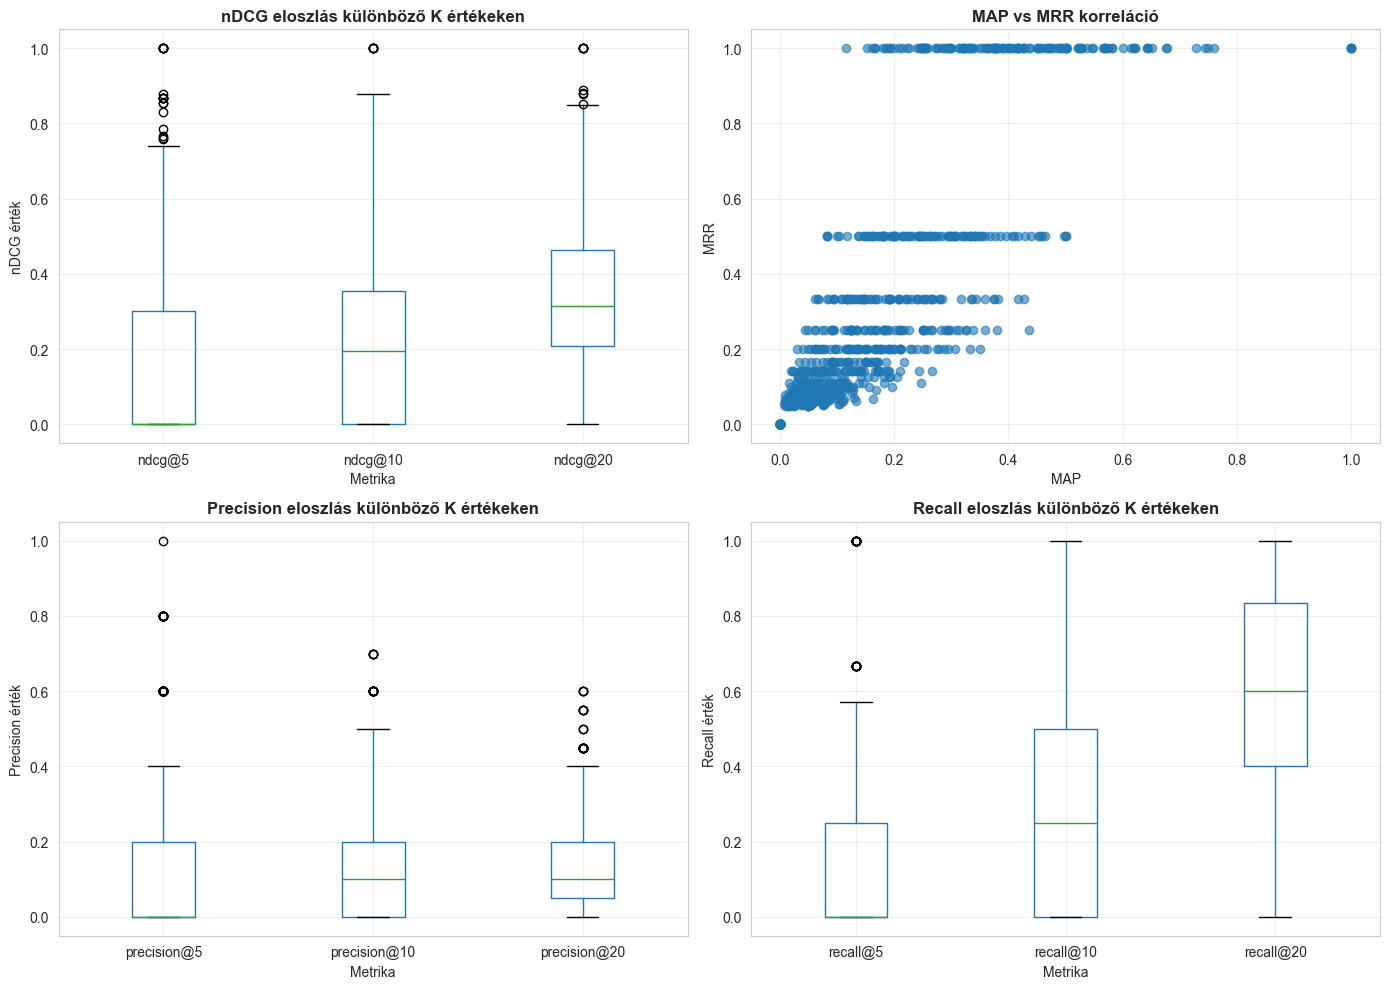

✅ Vizualizációk generálva


In [9]:
if not query_metrics_df.empty:
    # Stílus beállítása
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (14, 10)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. nDCG@K eloszlás
    ax1 = axes[0, 0]
    ndcg_cols = [col for col in query_metrics_df.columns if col.startswith('ndcg@')]
    query_metrics_df[ndcg_cols].boxplot(ax=ax1)
    ax1.set_title('nDCG eloszlás különböző K értékeken', fontsize=12, fontweight='bold')
    ax1.set_ylabel('nDCG érték')
    ax1.set_xlabel('Metrika')
    ax1.grid(True, alpha=0.3)
    
    # 2. MAP vs MRR
    ax2 = axes[0, 1]
    ax2.scatter(query_metrics_df['map'], query_metrics_df['mrr'], alpha=0.6)
    ax2.set_title('MAP vs MRR korreláció', fontsize=12, fontweight='bold')
    ax2.set_xlabel('MAP')
    ax2.set_ylabel('MRR')
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision@K eloszlás
    ax3 = axes[1, 0]
    prec_cols = [col for col in query_metrics_df.columns if col.startswith('precision@')]
    query_metrics_df[prec_cols].boxplot(ax=ax3)
    ax3.set_title('Precision eloszlás különböző K értékeken', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Precision érték')
    ax3.set_xlabel('Metrika')
    ax3.grid(True, alpha=0.3)
    
    # 4. Recall@K eloszlás
    ax4 = axes[1, 1]
    recall_cols = [col for col in query_metrics_df.columns if col.startswith('recall@')]
    query_metrics_df[recall_cols].boxplot(ax=ax4)
    ax4.set_title('Recall eloszlás különböző K értékeken', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Recall érték')
    ax4.set_xlabel('Metrika')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Vizualizációk generálva")


## 9. nDCG@10 Részletes Eloszlás


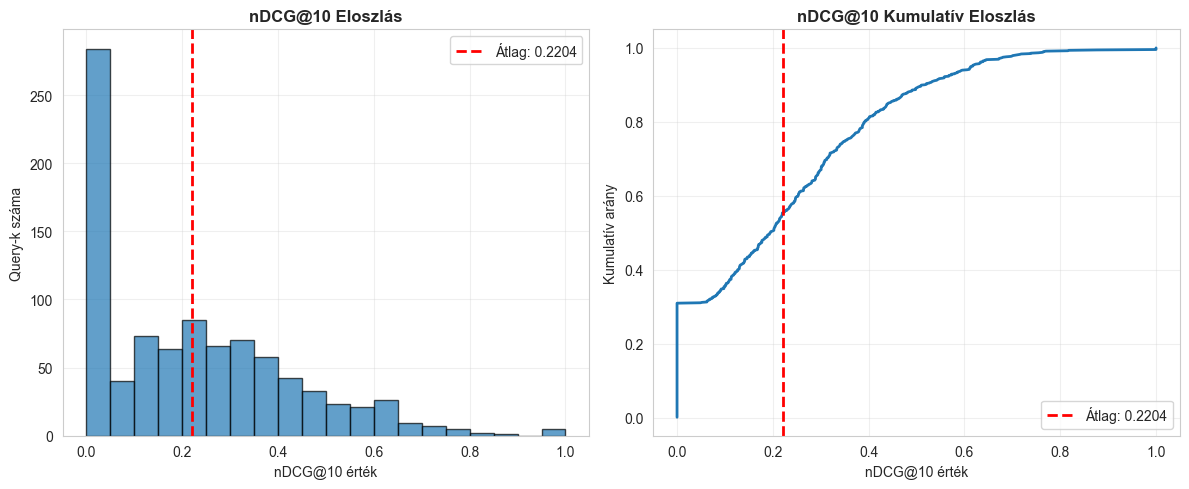


📊 nDCG@10 Percentilisek:
  • 10. percentilis: 0.0000
  • 25. percentilis: 0.0000
  • 50. percentilis: 0.1949
  • 75. percentilis: 0.3534
  • 90. percentilis: 0.5152


In [10]:
if not query_metrics_df.empty and 'ndcg@10' in query_metrics_df.columns:
    plt.figure(figsize=(12, 5))
    
    # Hisztogram
    plt.subplot(1, 2, 1)
    plt.hist(query_metrics_df['ndcg@10'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(aggregated_metrics['ndcg@10'], color='red', linestyle='--', linewidth=2, label=f'Átlag: {aggregated_metrics["ndcg@10"]:.4f}')
    plt.title('nDCG@10 Eloszlás', fontsize=12, fontweight='bold')
    plt.xlabel('nDCG@10 érték')
    plt.ylabel('Query-k száma')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Kumulatív eloszlás
    plt.subplot(1, 2, 2)
    sorted_ndcg = np.sort(query_metrics_df['ndcg@10'])
    cumulative = np.arange(1, len(sorted_ndcg) + 1) / len(sorted_ndcg)
    plt.plot(sorted_ndcg, cumulative, linewidth=2)
    plt.axvline(aggregated_metrics['ndcg@10'], color='red', linestyle='--', linewidth=2, label=f'Átlag: {aggregated_metrics["ndcg@10"]:.4f}')
    plt.title('nDCG@10 Kumulatív Eloszlás', fontsize=12, fontweight='bold')
    plt.xlabel('nDCG@10 érték')
    plt.ylabel('Kumulatív arány')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Percentilisek
    percentiles = [10, 25, 50, 75, 90]
    print("\n📊 nDCG@10 Percentilisek:")
    for p in percentiles:
        value = np.percentile(query_metrics_df['ndcg@10'], p)
        print(f"  • {p}. percentilis: {value:.4f}")


## 10. Eredmények Mentése


In [11]:
# Mentési útvonalak
output_dir = project_root / "data" / "models" / "grpo_policy"
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Aggregált metrikák JSON-ba
if aggregated_metrics:
    baseline_metrics_path = output_dir / "baseline_metrics.json"
    with open(baseline_metrics_path, 'w', encoding='utf-8') as f:
        json.dump(aggregated_metrics, f, indent=2, ensure_ascii=False)
    print(f"✅ Aggregált metrikák mentve: {baseline_metrics_path}")

# 2. Query-szintű eredmények CSV-be
if not query_metrics_df.empty:
    query_metrics_path = output_dir / "baseline_query_metrics.csv"
    query_metrics_df.to_csv(query_metrics_path, index=False, encoding='utf-8')
    print(f"✅ Query-szintű metrikák mentve: {query_metrics_path}")

# 3. Baseline találati listák JSONL-be (GRPO training inputhoz)
if baseline_results:
    baseline_results_path = output_dir / "baseline_results.jsonl"
    with open(baseline_results_path, 'w', encoding='utf-8') as f:
        for query_id, doc_ids in baseline_results.items():
            result_obj = {
                "query_id": query_id,
                "doc_ids": doc_ids,
                "num_results": len(doc_ids)
            }
            f.write(json.dumps(result_obj, ensure_ascii=False) + '\n')
    print(f"✅ Baseline találati listák mentve: {baseline_results_path}")

print("\n🎉 Minden eredmény sikeresen mentve!")


✅ Aggregált metrikák mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/models/grpo_policy/baseline_metrics.json
✅ Query-szintű metrikák mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/models/grpo_policy/baseline_query_metrics.csv
✅ Baseline találati listák mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/models/grpo_policy/baseline_results.jsonl

🎉 Minden eredmény sikeresen mentve!


## 11. Összefoglalás és Következő Lépések


In [12]:
print("\n" + "="*60)
print("📝 ÖSSZEFOGLALÁS")
print("="*60)

if aggregated_metrics:
    print(f"\n✅ Baseline értékelés sikeres:")
    print(f"   • nDCG@10: {aggregated_metrics.get('ndcg@10', 0.0):.4f}")
    print(f"   • MAP:     {aggregated_metrics.get('map', 0.0):.4f}")
    print(f"   • MRR:     {aggregated_metrics.get('mrr', 0.0):.4f}")
    
    print(f"\n📊 Cél a GRPO reranking után:")
    target_ndcg = aggregated_metrics.get('ndcg@10', 0.0) + 0.03
    print(f"   • Elvárt nDCG@10 javulás: ≥0.03")
    print(f"   • Célérték: ≥{target_ndcg:.4f}")
    print(f"   • Javulást elérő query-k aránya: ≥60%")
    
    print(f"\n🚀 Következő lépések:")
    print(f"   1. GRPO training notebook (grpo_train_runpod.ipynb) futtatása")
    print(f"   2. LoRA adapter training cloud környezetben")
    print(f"   3. Reranked eredmények kiértékelése")
    print(f"   4. Baseline vs. GRPO összehasonlítás")
else:
    print("\n⚠️  Nincs elérhető baseline eredmény")
    print("   Ellenőrizd a qrels fájlt és a hybrid_search komponenseket")

print("\n" + "="*60)



📝 ÖSSZEFOGLALÁS

✅ Baseline értékelés sikeres:
   • nDCG@10: 0.2204
   • MAP:     0.1718
   • MRR:     0.3186

📊 Cél a GRPO reranking után:
   • Elvárt nDCG@10 javulás: ≥0.03
   • Célérték: ≥0.2504
   • Javulást elérő query-k aránya: ≥60%

🚀 Következő lépések:
   1. GRPO training notebook (grpo_train_runpod.ipynb) futtatása
   2. LoRA adapter training cloud környezetben
   3. Reranked eredmények kiértékelése
   4. Baseline vs. GRPO összehasonlítás

